
# High-Dimensional Clustering Sims




Load libraries and set simple display options.

In [4]:

import time
from math import sqrt
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

from scipy.spatial.distance import pdist
from scipy.stats import wilcoxon

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import (
    adjusted_rand_score,
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)

# Global config
TOP_SEED = 137
OUTLIER_BOX_EXPAND = 3.5
DBSCAN_MIN_SAMPLES_FRAC = 0.01
DBSCAN_EPS_FACTOR = 0.9

ALGORITHMS = ("KMeans", "GMM", "Hierarchical(Ward)", "DBSCAN")  # GMM(BIC) handled separately
METRICS = ("ari", "silhouette", "ch", "dbi")

PLOT_SIL_BY_EXP = {
    "Exp1_Outliers": False,
    "Exp2_StdDev":   True,
    "Exp3_PCA_Dims": True,
    "Exp4_FeatureNoise": True,
}

# Show full tables inline
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 0)
np.set_printoptions(suppress=True, linewidth=120)


Make synthetic blobs with optional outliers and return masks and center separation.

In [6]:

def place_centers(k:int, d:int, min_sep:float, rng:np.random.Generator) -> np.ndarray:
    """Place k Gaussian centers in d dimensions roughly min_sep apart."""
    C = rng.normal(size=(k, d))
    if k > 1:
        cur_min = float(pdist(C, metric="euclidean").min())
        scale = (min_sep / cur_min) if cur_min > 0 else 1.0
    else:
        scale = 1.0
    return C * scale

def simulate_blobs(n_total:int, d:int, k:int, std:float, p_out:float,
                   min_sep:float, rng:np.random.Generator):
    """Simulate inlier Gaussian blobs with a uniform outlier box and track inlier mask."""
    n_inliers = int(round(n_total*(1-p_out)))
    n_out = n_total - n_inliers

    centers = place_centers(k, d, min_sep, rng)
    X_in, y_in = make_blobs(
        n_samples=n_inliers, centers=centers, cluster_std=std,
        n_features=d, random_state=int(rng.integers(0, 2**32-1))
    )

    if n_out > 0:
        mins = X_in.min(axis=0) - OUTLIER_BOX_EXPAND*std
        maxs = X_in.max(axis=0) + OUTLIER_BOX_EXPAND*std
        X_out = rng.uniform(low=mins, high=maxs, size=(n_out, d))
        X = np.vstack([X_in, X_out])
        y_true = np.concatenate([y_in, -1*np.ones(n_out, dtype=int)])
        inlier_mask = np.concatenate([np.ones(n_inliers, dtype=bool),
                                      np.zeros(n_out, dtype=bool)])
    else:
        X, y_true = X_in, y_in
        inlier_mask = np.ones(n_inliers, dtype=bool)

    md_min = float(pdist(centers, metric="euclidean").min()/std) if std > 0 and len(centers) > 1 else np.nan
    return X, y_true, inlier_mask, centers, md_min


Run clustering algorithms and collect timing and soft assignment diagnostics.

In [8]:

def _resp_diagnostics(gmm: GaussianMixture, X: np.ndarray):
    """Summarize GMM responsibilities with mean max prob, entropy, and ambiguity rate."""
    R = gmm.predict_proba(X)
    pmax = R.max(axis=1)
    with np.errstate(divide='ignore', invalid='ignore'):
        ent = -np.nansum(R * np.log(R + 1e-12), axis=1)
    return float(np.mean(pmax)), float(np.mean(ent)), float(np.mean(pmax < 0.7))

def run_algorithms_extended(X:np.ndarray, std_for_eps:float, n_clusters:int, seed:int):
    """Fit KMeans, GMM, Ward, DBSCAN and also do a BIC sweep for GMM(BIC)."""
    labels_map = {}
    info_map = {}
    rng_seed = int(seed)

    # KMeans
    t1 = time.perf_counter()
    km = KMeans(n_clusters=n_clusters, n_init=10, random_state=rng_seed)
    lab = km.fit_predict(X)
    t2 = time.perf_counter()
    labels_map["KMeans"] = lab
    info_map["KMeans"] = {"ExecTime_s": t2 - t1, "AIC": np.nan, "BIC": np.nan,
                          "K_sel": np.nan, "RespPmaxMean": np.nan,
                          "RespEntropyMean": np.nan, "RespAmbigFrac": np.nan}

    # GMM (fixed k)
    t1 = time.perf_counter()
    gmm = GaussianMixture(n_components=n_clusters, covariance_type="full",
                          random_state=rng_seed, n_init=1)
    gmm.fit(X)
    lab = gmm.predict(X)
    t2 = time.perf_counter()
    labels_map["GMM"] = lab
    pmax_mean, ent_mean, ambig_frac = _resp_diagnostics(gmm, X)
    info_map["GMM"] = {"ExecTime_s": t2 - t1, "AIC": float(gmm.aic(X)), "BIC": float(gmm.bic(X)),
                       "K_sel": float(n_clusters), "RespPmaxMean": pmax_mean,
                       "RespEntropyMean": ent_mean, "RespAmbigFrac": ambig_frac}

    # Hierarchical (Ward)
    t1 = time.perf_counter()
    agg = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
    lab = agg.fit_predict(X)
    t2 = time.perf_counter()
    labels_map["Hierarchical(Ward)"] = lab
    info_map["Hierarchical(Ward)"] = {"ExecTime_s": t2 - t1, "AIC": np.nan, "BIC": np.nan,
                                      "K_sel": np.nan, "RespPmaxMean": np.nan,
                                      "RespEntropyMean": np.nan, "RespAmbigFrac": np.nan}

    # DBSCAN
    d = X.shape[1]
    eps = DBSCAN_EPS_FACTOR * std_for_eps * sqrt(d)
    min_samples = max(5, int(DBSCAN_MIN_SAMPLES_FRAC*X.shape[0]))
    t1 = time.perf_counter()
    db = DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean")
    lab = db.fit_predict(X)
    t2 = time.perf_counter()
    labels_map["DBSCAN"] = lab
    info_map["DBSCAN"] = {"ExecTime_s": t2 - t1, "AIC": np.nan, "BIC": np.nan,
                          "K_sel": np.nan, "RespPmaxMean": np.nan,
                          "RespEntropyMean": np.nan, "RespAmbigFrac": np.nan}

    # GMM(BIC) model selection
    k_min = 1
    k_max = max(2, min(n_clusters * 2, n_clusters + 6))
    best_k = None; best_bic = np.inf; best_gmm = None
    t1 = time.perf_counter()
    for k in range(k_min, k_max + 1):
        g = GaussianMixture(n_components=k, covariance_type="full",
                            random_state=rng_seed, n_init=1)
        g.fit(X)
        bic = g.bic(X)
        if bic < best_bic:
            best_bic = bic
            best_k = k
            best_gmm = g
    lab_bic = best_gmm.predict(X)
    t2 = time.perf_counter()
    labels_map["GMM(BIC)"] = lab_bic
    pmax_mean_b, ent_mean_b, ambig_frac_b = _resp_diagnostics(best_gmm, X)
    info_map["GMM(BIC)"] = {"ExecTime_s": t2 - t1,
                            "AIC": float(best_gmm.aic(X)), "BIC": float(best_gmm.bic(X)),
                            "K_sel": float(best_k), "RespPmaxMean": pmax_mean_b,
                            "RespEntropyMean": ent_mean_b, "RespAmbigFrac": ambig_frac_b}
    return labels_map, info_map


Compute ARI and internal indices while guarding against degenerate cases.

In [10]:

def compute_metrics(X, y_true, inlier_mask, labels_pred):
    """Compute ARI on inliers and internal scores on non-noise clusters."""
    non_noise_mask = (labels_pred != -1)

    ari = np.nan
    if inlier_mask.sum() > 1:
        try:
            ari = adjusted_rand_score(y_true[inlier_mask], labels_pred[inlier_mask])
        except Exception:
            pass

    sil = ch = dbi = np.nan
    n_clusters_pred = len(np.unique(labels_pred[non_noise_mask])) if non_noise_mask.any() else 0
    if non_noise_mask.sum() >= 2 and n_clusters_pred >= 2:
        try: sil = silhouette_score(X[non_noise_mask], labels_pred[non_noise_mask])
        except Exception: pass
        try: ch = calinski_harabasz_score(X[non_noise_mask], labels_pred[non_noise_mask])
        except Exception: pass
        try: dbi = davies_bouldin_score(X[non_noise_mask], labels_pred[non_noise_mask])
        except Exception: pass

    return {"ari": float(ari),
            "silhouette": float(sil) if sil == sil else np.nan,
            "ch": float(ch) if ch == ch else np.nan,
            "dbi": float(dbi) if dbi == dbi else np.nan}


Aggregate metrics and add simple bootstrap confidence intervals.

In [12]:

def aggregate_basic(df: pd.DataFrame, exp_name: str, x_label: str) -> pd.DataFrame:
    """Summarize means, medians, quantiles, and timing by algorithm and x."""
    sub = df[df["experiment"] == exp_name]
    if sub.empty: return pd.DataFrame()
    grp = sub.groupby(["algorithm", "param_value"], as_index=False)
    out = grp.agg(
        **{f"{m}_mean": (m, "mean") for m in METRICS},
        **{f"{m}_median": (m, "median") for m in METRICS},
        **{f"{m}_q05": (m, lambda s: s.quantile(0.05)) for m in METRICS},
        **{f"{m}_q95": (m, lambda s: s.quantile(0.95)) for m in METRICS},
        mahalanobis_min_mean=("mahalanobis_min", "mean"),
        ExecTime_s_mean=("ExecTime_s", "mean"),
        ExecTime_s_median=("ExecTime_s", "median"),
        ExecTime_s_q05=("ExecTime_s", lambda s: s.quantile(0.05)),
        ExecTime_s_q95=("ExecTime_s", lambda s: s.quantile(0.95)),
    ).rename(columns={"param_value": x_label})
    return out

def bootstrap_ci(values: np.ndarray, B:int=1000, rng=None, stat:str="mean", alpha:float=0.05):
    """Bootstrap a mean or median with simple percentile bands."""
    if rng is None: rng = np.random.default_rng(TOP_SEED)
    x = np.asarray(values, dtype=float)
    x = x[~np.isnan(x)]
    if x.size == 0: return np.nan, np.nan, np.nan
    if x.size == 1: return float(x[0]), float(x[0]), float(x[0])
    boots = np.empty(B, dtype=float)
    for b in range(B):
        sample = x[rng.integers(0, x.size, size=x.size)]
        boots[b] = (np.mean(sample) if stat == "mean" else np.median(sample))
    hat = np.mean(x) if stat == "mean" else np.median(x)
    lo = float(np.quantile(boots, alpha/2))
    hi = float(np.quantile(boots, 1-alpha/2))
    return float(hat), lo, hi

def add_ari_bootstrap(df_all: pd.DataFrame, exp_name: str, x_label: str, B:int, rng) -> pd.DataFrame:
    """Attach ARI bootstrap means and intervals for plotting and tables."""
    sub = df_all[df_all["experiment"] == exp_name]
    if sub.empty: return pd.DataFrame()
    rows = []
    for (algo, xval), g in sub.groupby(["algorithm", "param_value"], as_index=False):
        vals = g["ari"].to_numpy()
        mean_hat, mean_lo, mean_hi = bootstrap_ci(vals, B=B, rng=rng, stat="mean")
        med_hat,  med_lo,  med_hi  = bootstrap_ci(vals, B=B, rng=rng, stat="median")
        rows.append({
            "experiment": exp_name, "algorithm": algo, x_label: xval,
            "ari_mean": np.nanmean(vals), "ari_median": np.nanmedian(vals),
            "ari_q05": np.nanquantile(vals, 0.05), "ari_q95": np.nanquantile(vals, 0.95),
            "ari_mean_lo": mean_lo, "ari_mean_hi": mean_hi,
            "ari_median_lo": med_lo, "ari_median_hi": med_hi,
            "mahalanobis_min_mean": float(np.nanmean(g["mahalanobis_min"].values)),
        })
    return pd.DataFrame(rows)

def add_bootstrap_for_metrics(df_all: pd.DataFrame, exp_name: str, x_label: str,
                              metrics:list, B:int, rng) -> pd.DataFrame:
    """Compute mean and bootstrap bands for a list of metrics for inline plots."""
    sub = df_all[df_all["experiment"] == exp_name]
    if sub.empty: return pd.DataFrame()
    rows = []
    for (algo, xval), g in sub.groupby(["algorithm", "param_value"], as_index=False):
        row = {"algorithm": algo, x_label: xval}
        for m in metrics:
            vals = g[m].to_numpy(dtype=float)
            mean_simple = float(np.nanmean(vals)) if np.isfinite(vals).any() else np.nan
            _, lo, hi = bootstrap_ci(vals, B=B, rng=rng, stat="mean")
            row[f"{m}_mean"] = mean_simple
            row[f"{m}_lo"] = lo
            row[f"{m}_hi"] = hi
        rows.append(row)
    return pd.DataFrame(rows)


Plot simple lines, errorbars, and overlays without forcing colors.

In [14]:

def plot_mean(df_agg: pd.DataFrame, x_name: str, metric_key: str, y_label: str, title: str):
    """Draw mean metric vs x using default matplotlib styling."""
    if df_agg.empty: 
        print(f"[plot_mean] No data for {title}")
        return
    plt.figure()
    algos = sorted([a for a in df_agg["algorithm"].unique() if a != "GMM(BIC)"])
    for algo in algos:
        sub = df_agg[df_agg["algorithm"] == algo].sort_values(x_name)
        x = sub[x_name].values
        y = sub[f"{metric_key}_mean"].values
        plt.plot(x, y, label=algo, marker="o", linewidth=2.0, markersize=5)
    ax = plt.gca()
    ax.yaxis.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.25)
    ax.xaxis.grid(False); ax.set_axisbelow(True)
    plt.xlabel(x_name); plt.ylabel(y_label); plt.title(title)
    plt.legend(loc="best", frameon=True)
    plt.show()

def plot_vs_mahalanobis(df_agg: pd.DataFrame, metric_key: str, y_label: str, title: str):
    """Plot mean metric against the minimum center separation proxy."""
    if df_agg.empty: 
        print(f"[plot_vs_mahalanobis] No data for {title}")
        return
    plt.figure()
    algos = sorted([a for a in df_agg["algorithm"].unique() if a != "GMM(BIC)"])
    for algo in algos:
        sub = df_agg[df_agg["algorithm"] == algo].sort_values("mahalanobis_min_mean")
        x = sub["mahalanobis_min_mean"].values
        y = sub[f"{metric_key}_mean"].values
        plt.plot(x, y, label=algo, marker="o", linewidth=2.0, markersize=5)
    ax = plt.gca()
    ax.yaxis.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.25)
    ax.xaxis.grid(False); ax.set_axisbelow(True)
    plt.xlabel("Min Mahalanobis separation (centers)"); plt.ylabel(y_label); plt.title(title)
    plt.legend(loc="best", frameon=True)
    plt.show()

def plot_mean_with_ci(df_boot: pd.DataFrame, x_name: str, metric_key: str, y_label: str, title: str):
    """Plot mean with bootstrap error bars using defaults for a clean look."""
    if df_boot.empty: 
        print(f"[plot_mean_with_ci] No data for {title}")
        return
    plt.figure()
    algos = sorted([a for a in df_boot["algorithm"].unique() if a != "GMM(BIC)"])
    for algo in algos:
        sub = df_boot[df_boot["algorithm"] == algo].sort_values(x_name)
        if sub.empty: continue
        x = sub[x_name].to_numpy()
        y = sub[f"{metric_key}_mean"].to_numpy()
        lo = sub[f"{metric_key}_lo"].to_numpy()
        hi = sub[f"{metric_key}_hi"].to_numpy()
        mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(lo) & np.isfinite(hi)
        x, y, lo, hi = x[mask], y[mask], lo[mask], hi[mask]
        if x.size == 0: continue
        yerr = np.vstack([y - lo, hi - y])
        plt.errorbar(x, y, yerr=yerr, label=algo, marker="o", linewidth=2.0, markersize=5, capsize=3)
    ax = plt.gca()
    ax.yaxis.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.25)
    ax.xaxis.grid(False); ax.set_axisbelow(True)
    plt.xlabel(x_name); plt.ylabel(y_label); plt.title(title + " (mean ± bootstrap CI)")
    plt.legend(loc="best", frameon=True)
    plt.show()

def plot_with_seed_overlays(df_long: pd.DataFrame, df_agg: pd.DataFrame,
                            exp_name: str, x_name: str, title_prefix: str, plot_sil: bool):
    """Overlay per-seed points atop mean lines for a richer picture."""
    if df_agg.empty: 
        print(f"[plot_with_seed_overlays] No data for {title_prefix}")
        return
    metrics = ["ari", "ch", "dbi"] + (["silhouette"] if plot_sil else [])
    xvals = df_agg[x_name].values
    x_range = float(np.max(xvals) - np.min(xvals)) if xvals.size > 0 else 1.0
    jitter = 0.02 * x_range if x_range > 0 else 0.2

    for metric_key in metrics:
        plt.figure()
        algos = sorted([a for a in df_agg["algorithm"].unique() if a != "GMM(BIC)"])
        for algo in algos:
            subm = df_agg[df_agg["algorithm"] == algo].sort_values(x_name)
            x = subm[x_name].values
            y = subm[f"{metric_key}_mean"].values
            plt.plot(x, y, label=algo, marker="o", linewidth=2.0, markersize=5)
            subd = df_long[(df_long["experiment"] == exp_name) & (df_long["algorithm"] == algo)]
            for xv, g in subd.groupby("param_value"):
                xs = np.full(len(g), xv, dtype=float) + np.random.uniform(-jitter, jitter, size=len(g))
                plt.scatter(xs, g[metric_key].values, s=14, alpha=0.30, edgecolors="none")
        ylabel = {
            "ari": "Adjusted Rand Index",
            "silhouette": "Silhouette (non-noise only)",
            "ch": "Calinski–Harabasz (higher=better)",
            "dbi": "Davies–Bouldin (lower=better)",
        }[metric_key]
        ax = plt.gca()
        ax.yaxis.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.25)
        ax.xaxis.grid(False); ax.set_axisbelow(True)
        plt.xlabel(x_name); plt.ylabel(ylabel)
        plt.title(f"{title_prefix}: {ylabel} vs {x_name} (means + per-seed)")
        plt.legend(loc="best", frameon=True)
        plt.show()


Loop over grids and seeds to run the full suite of experiments.

In [16]:

def run_experiment(exp_name, grid, data_generator, seeds, std_for_eps_hint=None, K=4):
    """Run an experiment grid across seeds and collect metrics and diagnostics."""
    records = []
    for val in grid:
        for seed in seeds:
            rng = np.random.default_rng(int(seed) + TOP_SEED)
            X, y_true, inlier_mask, centers, md_min = data_generator(val, rng)

            std_for_eps = std_for_eps_hint
            if std_for_eps is None:
                std_for_eps = float(val) if isinstance(val, (float, int)) else 1.0

            labels_map, info_map = run_algorithms_extended(X, std_for_eps, K, seed=int(seed))

            for algo_name, labels in labels_map.items():
                m = compute_metrics(X, y_true, inlier_mask, labels)
                inf = info_map.get(algo_name, {})
                rec = {
                    "experiment": exp_name,
                    "param_value": val,
                    "algorithm": algo_name,
                    **m,
                    "seed": int(seed),
                    "n": X.shape[0],
                    "d": X.shape[1],
                    "mahalanobis_min": md_min,
                    "ExecTime_s": float(inf.get("ExecTime_s", np.nan)),
                    "AIC": float(inf.get("AIC", np.nan)),
                    "BIC": float(inf.get("BIC", np.nan)),
                    "K_sel": float(inf.get("K_sel", np.nan)),
                    "RespPmaxMean": float(inf.get("RespPmaxMean", np.nan)),
                    "RespEntropyMean": float(inf.get("RespEntropyMean", np.nan)),
                    "RespAmbigFrac": float(inf.get("RespAmbigFrac", np.nan)),
                }
                records.append(rec)
    return pd.DataFrame.from_records(records)


Pick a preset and provide a paired Wilcoxon with BH‑FDR across algorithms.

In [18]:

def get_preset(preset:str):
    """Return quick or full experiment grids and seeds."""
    rng = np.random.default_rng(TOP_SEED)
    if preset == "quick":
        return {
            "N": 1000, "D": 100, "K": 4, "CENTER_MIN_SEP": 6.0,
            "GRID_EXP1_P_OUT": [0.0, 0.1, 0.2],
            "GRID_EXP2_STD": [0.6, 1.0, 1.4],
            "GRID_EXP3_PCA_DIMS": [2, 10, 50, 100],
            "GRID_EXP4_NOISE_FEATURES": [0, 20, 60],
            "SEEDS": list(rng.integers(0, 10_000, size=5)),
            "BOOTSTRAP_B": 500,
        }
    elif preset == "full":
        return {
            "N": 2000, "D": 100, "K": 4, "CENTER_MIN_SEP": 6.0,
            "GRID_EXP1_P_OUT": [0.0, 0.05, 0.1, 0.2, 0.3],
            "GRID_EXP2_STD": [0.4, 0.8, 1.2, 1.6, 2.0],
            "GRID_EXP3_PCA_DIMS": [2, 10, 50, 100],
            "GRID_EXP4_NOISE_FEATURES": [0, 10, 30, 60, 100],
            "SEEDS": list(rng.integers(0, 10_000, size=10)),
            "BOOTSTRAP_B": 1000,
        }
    else:
        raise ValueError("preset must be 'quick' or 'full'")

def pairwise_significance(df_all: pd.DataFrame, exp_name: str, B:int=1000) -> pd.DataFrame:
    """Compute Wilcoxon signed‑rank tests on per‑seed ARI differences with BH‑FDR."""
    sub = df_all[df_all["experiment"] == exp_name].copy()
    if sub.empty: return pd.DataFrame()
    rows = []
    for xval, g in sub.groupby("param_value"):
        piv = g.pivot_table(index="seed", columns="algorithm", values="ari", aggfunc="mean")
        algos = list(piv.columns)
        for i in range(len(algos)):
            for j in range(i+1, len(algos)):
                a, b = algos[i], algos[j]
                a_vals = piv[a].to_numpy()
                b_vals = piv[b].to_numpy()
                mask = np.isfinite(a_vals) & np.isfinite(b_vals)
                d = (a_vals - b_vals)[mask]
                n = d.size
                if n < 5:
                    stat = np.nan; pval = np.nan
                    mean_diff = float(np.nanmean(d)) if n>0 else np.nan
                    median_diff = float(np.nanmedian(d)) if n>0 else np.nan
                    lo = hi = np.nan
                else:
                    if np.all(d == 0):
                        stat, pval = 0.0, 1.0
                        mean_diff, median_diff = 0.0, 0.0
                        lo, hi = 0.0, 0.0
                    else:
                        try:
                            stat, pval = wilcoxon(d, zero_method="wilcox", correction=False,
                                                  alternative="two-sided", mode="auto")
                        except ValueError:
                            stat, pval = wilcoxon(d, zero_method="zsplit", correction=False,
                                                  alternative="two-sided", mode="auto")
                        mean_diff = float(np.mean(d))
                        median_diff = float(np.median(d))
                        _, lo, hi = bootstrap_ci(
                            d, B=B, rng=np.random.default_rng(TOP_SEED+2024), stat="mean"
                        )
                rows.append({
                    "experiment": exp_name,
                    "param_value": xval,
                    "algo_A": a, "algo_B": b,
                    "n_pairs": int(n),
                    "wilcoxon_stat": float(stat) if np.isfinite(stat) else np.nan,
                    "p_value": float(pval) if np.isfinite(pval) else np.nan,
                    "mean_diff_A_minus_B": mean_diff,
                    "median_diff_A_minus_B": median_diff,
                    "boot_mean_diff_lo": lo,
                    "boot_mean_diff_hi": hi,
                })
    out = pd.DataFrame(rows)
    if not out.empty and out["p_value"].notna().any():
        out["p_adj_BH"] = np.nan
        for xval, g in out.groupby("param_value"):
            p = g["p_value"].to_numpy()
            m = np.isfinite(p)
            p_clean = p[m]
            if p_clean.size > 0:
                order = np.argsort(p_clean)
                ranks = np.empty_like(order); ranks[order] = np.arange(1, p_clean.size+1)
                bh = p_clean * p_clean.size / ranks
                bh = np.minimum.accumulate(bh[order[::-1]])[::-1]
                p_adj = np.minimum(1.0, bh)
                p_full = np.full_like(p, fill_value=np.nan, dtype=float)
                p_full[m] = p_adj
                out.loc[g.index, "p_adj_BH"] = p_full
    return out


Choose a preset and run Exp1–Exp4 to build the long results table.

In [20]:

preset = "quick"  # change to "full" for a heavier run
cfg = get_preset(preset)
N = cfg["N"]; D = cfg["D"]; K_clusters = cfg["K"]; CENTER_MIN_SEP = cfg["CENTER_MIN_SEP"]
SEEDS = cfg["SEEDS"]; B = cfg["BOOTSTRAP_B"]

def gen_exp1(p_out, rng):
    """Generate data for the outlier experiment with fixed std."""
    return simulate_blobs(N, D, K_clusters, std=1.0, p_out=p_out, min_sep=CENTER_MIN_SEP, rng=rng)
def gen_exp2(std, rng):
    """Generate data for the std‑sweep experiment with 10% outliers."""
    return simulate_blobs(N, D, K_clusters, std=float(std), p_out=0.10, min_sep=CENTER_MIN_SEP, rng=rng)
def gen_exp3(pca_dim, rng):
    """Generate base data then project to k dimensions via PCA."""
    X, y_true, inlier_mask, centers, md_min = simulate_blobs(N, D, K_clusters, std=1.0, p_out=0.10,
                                                             min_sep=CENTER_MIN_SEP, rng=rng)
    pca = PCA(n_components=int(pca_dim), random_state=int(rng.integers(0, 2**32-1)))
    Xp = pca.fit_transform(X)
    return Xp, y_true, inlier_mask, centers[:, :min(centers.shape[1], int(pca_dim))], md_min
def gen_exp4(n_noise, rng):
    """Generate base data and add pure noise features to test robustness."""
    X, y_true, inlier_mask, centers, md_min = simulate_blobs(N, D, K_clusters, std=1.0, p_out=0.10,
                                                             min_sep=CENTER_MIN_SEP, rng=rng)
    n_noise = int(n_noise)
    if n_noise > 0:
        noise = rng.normal(size=(X.shape[0], n_noise))
        X = np.hstack([X, noise])
    return X, y_true, inlier_mask, centers, md_min

all_results = []
df1 = run_experiment("Exp1_Outliers", cfg["GRID_EXP1_P_OUT"], gen_exp1, SEEDS, std_for_eps_hint=1.0, K=K_clusters)
df2 = run_experiment("Exp2_StdDev",   cfg["GRID_EXP2_STD"],   gen_exp2, SEEDS, std_for_eps_hint=None, K=K_clusters)
df3 = run_experiment("Exp3_PCA_Dims", cfg["GRID_EXP3_PCA_DIMS"], gen_exp3, SEEDS, std_for_eps_hint=1.0, K=K_clusters)
df4 = run_experiment("Exp4_FeatureNoise", cfg["GRID_EXP4_NOISE_FEATURES"], gen_exp4, SEEDS, std_for_eps_hint=1.0, K=K_clusters)

df_all = pd.concat([df1, df2, df3, df4], ignore_index=True)
print("df_all shape:", df_all.shape)
display(df_all)


C:\Users\srivalli\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\srivalli\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\srivalli\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\srivalli\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory le

df_all shape: (325, 18)


experiment  param_value           algorithm       ari  silhouette  \
0        Exp1_Outliers          0.0              KMeans  0.992013    0.073935   
1        Exp1_Outliers          0.0                 GMM  0.626436    0.044601   
2        Exp1_Outliers          0.0  Hierarchical(Ward)  0.919282    0.069983   
3        Exp1_Outliers          0.0              DBSCAN  0.000000         NaN   
4        Exp1_Outliers          0.0            GMM(BIC)  0.000000         NaN   
5        Exp1_Outliers          0.0              KMeans  0.989355    0.077842   
6        Exp1_Outliers          0.0                 GMM  0.989355    0.077842   
7        Exp1_Outliers          0.0  Hierarchical(Ward)  0.926665    0.074593   
8        Exp1_Outliers          0.0              DBSCAN  0.000000         NaN   
9        Exp1_Outliers          0.0            GMM(BIC)  0.000000         NaN   
10       Exp1_Outliers          0.0              KMeans  0.991992    0.072773   
11       Exp1_Outliers          0.0                 GMM  0.991992    0.072773   
12       Exp1_Outliers          0.0  Hierarchical(Ward)  0.926544    0.069714   
13       Exp1_Outliers          0.0              DBSCAN  0.000000         NaN   
14       Exp1_Outliers          0.0            GMM(BIC)  0.000000         NaN   
15       Exp1_Outliers          0.0              KMeans  0.994672    0.075542   
16       Exp1_Outliers          0.0                 GMM  0.994672    0.075542   
17       Exp1_Outliers          0.0  Hierarchical(Ward)  0.926938    0.072003   
18       Exp1_Outliers          0.0              DBSCAN  0.000000         NaN   
19       Exp1_Outliers          0.0            GMM(BIC)  0.000000         NaN   
20       Exp1_Outliers          0.0              KMeans  0.989339    0.068883   
21       Exp1_Outliers          0.0                 GMM  0.626077    0.035033   
22       Exp1_Outliers          0.0  Hierarchical(Ward)  0.903377    0.064977   
23       Exp1_Outliers          0.0              DBSCAN  0.000000         NaN   
24       Exp1_Outliers          0.0            GMM(BIC)  0.000000         NaN   
25       Exp1_Outliers          0.1              KMeans  0.994074    0.053934   
26       Exp1_Outliers          0.1                 GMM  0.678356    0.045771   
27       Exp1_Outliers          0.1  Hierarchical(Ward)  0.959196   -0.031842   
28       Exp1_Outliers          0.1              DBSCAN  0.000000         NaN   
29       Exp1_Outliers          0.1            GMM(BIC)  0.012488    0.320276   
30       Exp1_Outliers          0.1              KMeans  0.994074    0.053135   
31       Exp1_Outliers          0.1                 GMM  0.681241    0.048686   
32       Exp1_Outliers          0.1  Hierarchical(Ward)  0.927048   -0.009799   
33       Exp1_Outliers          0.1              DBSCAN  0.000000         NaN   
34       Exp1_Outliers          0.1            GMM(BIC)  0.000000         NaN   
35       Exp1_Outliers          0.1              KMeans  0.991114    0.053836   
36       Exp1_Outliers          0.1                 GMM  0.625915    0.044730   
37       Exp1_Outliers          0.1  Hierarchical(Ward)  0.933005    0.029010   
38       Exp1_Outliers          0.1              DBSCAN  0.000000         NaN   
39       Exp1_Outliers          0.1            GMM(BIC)  0.000000         NaN   
40       Exp1_Outliers          0.1              KMeans  0.997034    0.049859   
41       Exp1_Outliers          0.1                 GMM  0.690647    0.040141   
42       Exp1_Outliers          0.1  Hierarchical(Ward)  0.915563   -0.037651   
43       Exp1_Outliers          0.1              DBSCAN  0.000000         NaN   
44       Exp1_Outliers          0.1            GMM(BIC)  0.000249    0.477838   
45       Exp1_Outliers          0.1              KMeans  0.973436    0.026850   
46       Exp1_Outliers          0.1                 GMM  0.964704    0.026300   
47       Exp1_Outliers          0.1  Hierarchical(Ward)  0.909752   -0.039926   
48       Exp1_Outliers          0.1        

Summarize metrics by algorithm and x for each experiment.

In [22]:

agg1 = aggregate_basic(df_all, "Exp1_Outliers", "Outlier_Proportion")
agg2 = aggregate_basic(df_all, "Exp2_StdDev", "Cluster_StdDev")
agg3 = aggregate_basic(df_all, "Exp3_PCA_Dims", "PCA_Dimensions")
agg4 = aggregate_basic(df_all, "Exp4_FeatureNoise", "Num_Noise_Features")

print("\nagg1 (Exp1_Outliers)")
display(agg1)
print("\nagg2 (Exp2_StdDev)")
display(agg2)
print("\nagg3 (Exp3_PCA_Dims)")
display(agg3)
print("\nagg4 (Exp4_FeatureNoise)")
display(agg4)



agg1 (Exp1_Outliers)


algorithm  Outlier_Proportion  ari_mean  silhouette_mean  \
0               DBSCAN                 0.0  0.000000              NaN   
1               DBSCAN                 0.1  0.000000              NaN   
2               DBSCAN                 0.2  0.000000              NaN   
3                  GMM                 0.0  0.845706         0.061158   
4                  GMM                 0.1  0.728173         0.041126   
5                  GMM                 0.2  0.000373         0.428411   
6             GMM(BIC)                 0.0  0.000000              NaN   
7             GMM(BIC)                 0.1  0.002547         0.399057   
8             GMM(BIC)                 0.2  0.000373         0.404369   
9   Hierarchical(Ward)                 0.0  0.920561         0.070254   
10  Hierarchical(Ward)                 0.1  0.928913        -0.018042   
11  Hierarchical(Ward)                 0.2  0.769616        -0.013918   
12              KMeans                 0.0  0.991474         0.073795   
13              KMeans                 0.1  0.989947         0.047523   
14              KMeans                 0.2  0.756599         0.013946   

      ch_mean  dbi_mean  ari_median  silhouette_median  ch_median  dbi_median  \
0         NaN       NaN    0.000000                NaN        NaN         NaN   
1         NaN       NaN    0.000000                NaN        NaN         NaN   
2         NaN       NaN    0.000000                NaN        NaN         NaN   
3   47.474773  4.107628    0.989355           0.072773  53.222819    3.251790   
4   18.781284  3.580709    0.681241           0.044730  18.295764    3.439631   
5    6.938147  4.617014    0.000000           0.441610   6.836114    4.763975   
6         NaN       NaN    0.000000                NaN        NaN         NaN   
7    9.763982  6.932910    0.000000           0.399057   9.763982    6.932910   
8    7.474402  5.293561    0.000000           0.404369   7.474402    5.293561   
9   51.583758  3.293302    0.926544           0.069983  52.205231    3.286769   
10  19.639814  4.475941    0.927048          -0.031842  19.908202    4.412391   
11  12.166410  5.702040    0.683966          -0.022560  12.377662    5.650002   
12  53.651723  3.224191    0.991992           0.073935  54.254677    3.216403   
13  22.943450  4.066025    0.994074           0.053135  22.989107    4.074563   
14  14.933883  4.904964    0.701378           0.013763  14.951556    4.853406   

     ari_q05  silhouette_q05     ch_q05   dbi_q05   ari_q95  silhouette_q95  \
0   0.000000             NaN        NaN       NaN  0.000000             NaN   
1   0.000000             NaN        NaN       NaN  0.000000             NaN   
2   0.000000             NaN        NaN       NaN  0.000000             NaN   
3   0.626149        0.036947  36.008931  3.167072  0.994136        0.077382   
4   0.636403        0.029068  17.220613  3.324072  0.909893        0.048103   
5   0.000000        0.385186   5.682150  3.624163  0.001446        0.447682   
6   0.000000             NaN        NaN       NaN  0.000000             NaN   
7   0.000000        0.328154   9.390676  6.806173  0.010040        0.469960   
8   0.000000        0.375594   6.899943  5.118689  0.001446        0.433143   
9   0.906558        0.065924  48.488594  3.248003  0.926883        0.074075   
10  0.910915       -0.039471  18.722611  4.311808  0.953958        0.021248   
11  0.654625       -0.032544  11.548916  5.424196  0.918390        0.017256   
12  0.989342        0.069661  50.725332  3.167072  0.994140        0.077382   
13  0.976972        0.031451  21.884520  3.996217  0.996442        0.053915   
14  0.693871        0.008254  14.437659  4.793690  0.926128        0.020072   

       ch_q95   dbi_q95  mahalanobis_min_mean  ExecTime_s_mean  \
0         NaN       NaN                   6.0         0.062151   
1         NaN       NaN                   6.0         0.053814   
2         NaN       NaN                   6.0         0.065414   
3   55.612934  5.4


agg2 (Exp2_StdDev)


algorithm  Cluster_StdDev  ari_mean  silhouette_mean    ch_mean  \
0               DBSCAN             0.6  0.000000              NaN        NaN   
1               DBSCAN             1.0  0.000000              NaN        NaN   
2               DBSCAN             1.4  0.000000              NaN        NaN   
3                  GMM             0.6  0.828162         0.113636  44.480583   
4                  GMM             1.0  0.728173         0.041126  18.781284   
5                  GMM             1.4  0.207508         0.077399   9.364984   
6             GMM(BIC)             0.6  0.000000              NaN        NaN   
7             GMM(BIC)             1.0  0.002547         0.399057   9.763982   
8             GMM(BIC)             1.4  0.000401         0.461613   9.593022   
9   Hierarchical(Ward)             0.6  0.999407         0.061037  48.778901   
10  Hierarchical(Ward)             1.0  0.928913        -0.018042  19.639814   
11  Hierarchical(Ward)             1.4  0.000000         0.544735  12.906956   
12              KMeans             0.6  1.000000         0.128842  54.285824   
13              KMeans             1.0  0.989947         0.047523  22.943450   
14              KMeans             1.4  0.605583         0.014792  13.866277   

    dbi_mean  ari_median  silhouette_median  ch_median  dbi_median   ari_q05  \
0        NaN    0.000000                NaN        NaN         NaN  0.000000   
1        NaN    0.000000                NaN        NaN         NaN  0.000000   
2        NaN    0.000000                NaN        NaN         NaN  0.000000   
3   2.440687    0.713603           0.111578  39.401981    2.338287  0.713603   
4   3.580709    0.681241           0.044730  18.295764    3.439631  0.636403   
5   5.200555    0.267050           0.040197   9.336771    5.147069  0.058978   
6        NaN    0.000000                NaN        NaN         NaN  0.000000   
7   6.932910    0.000000           0.399057   9.763982    6.932910  0.000000   
8   7.166862    0.000027           0.462789   9.520662    7.119059  0.000000   
9   2.890602    1.000000           0.060102  48.574974    2.842597  0.997627   
10  4.475941    0.927048          -0.031842  19.908202    4.412391  0.910915   
11  4.147441    0.000000           0.544684  13.044993    4.226776  0.000000   
12  2.614570    1.000000           0.132385  54.670960    2.635271  1.000000   
13  4.066025    0.994074           0.053135  22.989107    4.074563  0.976972   
14  5.268047    0.616244           0.015537  13.832620    5.239440  0.554600   

    silhouette_q05     ch_q05   dbi_q05   ari_q95  silhouette_q95     ch_q95  \
0              NaN        NaN       NaN  0.000000             NaN        NaN   
1              NaN        NaN       NaN  0.000000             NaN        NaN   
2              NaN        NaN       NaN  0.000000             NaN        NaN   
3         0.100068  37.244542  2.291273  1.000000        0.127563  55.169983   
4         0.029068  17.220613  3.324072  0.909893        0.048103  21.101047   
5         0.004654   7.789181  4.418230  0.321905        0.174855  11.531794   
6              NaN        NaN       NaN  0.000000             NaN        NaN   
7         0.328154   9.390676  6.806173  0.010040        0.469960  10.137289   
8         0.420963   9.058782  7.029844  0.001486        0.501441  10.177913   
9         0.055815  46.761704  2.736661  1.000000        0.067587  50.302936   
10       -0.039471  18.722611  4.311808  0.953958        0.021248  20.109507   
11        0.541445  12.394798  3.579034  0.000000        0.548210  13.171275   
12        0.116874  51.834753  2.538220  1.000000        0.136452  56.004802   
13        0.031451  21.884520  3.996217  0.996442        0.053915  23.682269   
14        0.011862  13.123291  5.150306  0.649359        0.017048  14.646630   

     dbi_q95  mahalanobis_min_mean  ExecTime_s_mean  ExecTime_s_median  \
0        NaN             10.000000         0.063784           0.059404   
1        NaN          


agg3 (Exp3_PCA_Dims)


algorithm  PCA_Dimensions      ari_mean  silhouette_mean  \
0               DBSCAN             2.0  9.805411e-09              NaN   
1               DBSCAN            10.0  3.965118e-01         0.305324   
2               DBSCAN            50.0  0.000000e+00              NaN   
3               DBSCAN           100.0  0.000000e+00              NaN   
4                  GMM             2.0  6.690620e-01         0.493938   
5                  GMM            10.0  5.532528e-01         0.212161   
6                  GMM            50.0  2.741057e-04         0.545226   
7                  GMM           100.0  7.281728e-01         0.041126   
8             GMM(BIC)             2.0  6.690620e-01         0.493938   
9             GMM(BIC)            10.0  7.043254e-01         0.223649   
10            GMM(BIC)            50.0  4.815234e-04         0.540768   
11            GMM(BIC)           100.0  2.547397e-03         0.399057   
12  Hierarchical(Ward)             2.0  6.956801e-01         0.431713   
13  Hierarchical(Ward)            10.0  9.625790e-01         0.205400   
14  Hierarchical(Ward)            50.0  9.417332e-01         0.011596   
15  Hierarchical(Ward)           100.0  9.289132e-01        -0.018042   
16              KMeans             2.0  7.624690e-01         0.471255   
17              KMeans            10.0  9.863991e-01         0.246472   
18              KMeans            50.0  9.917170e-01         0.077413   
19              KMeans           100.0  9.899465e-01         0.047523   

       ch_mean  dbi_mean  ari_median  silhouette_median   ch_median  \
0          NaN       NaN    0.000000                NaN         NaN   
1   302.297522  1.272084    0.560437           0.317610  315.214462   
2          NaN       NaN    0.000000                NaN         NaN   
3          NaN       NaN    0.000000                NaN         NaN   
4   326.060162  3.906800    0.671966           0.501962  318.217176   
5    53.211194  6.124975    0.678097           0.205536   49.773839   
6    10.959228  4.386757    0.000010           0.579022   11.074483   
7    18.781284  3.580709    0.681241           0.044730   18.295764   
8   326.060162  3.906800    0.671966           0.501962  318.217176   
9    56.644991  5.904104    0.712153           0.225128   55.730614   
10   10.623128  5.820558    0.000000           0.588665   11.339243   
11    9.763982  6.932910    0.000000           0.399057    9.763982   
12  685.098032  0.789899    0.721092           0.412062  656.440911   
13   86.754735  1.910797    0.961972           0.205054   88.552875   
14   26.154099  3.574959    0.947356           0.018371   26.461411   
15   19.639814  4.475941    0.927048          -0.031842   19.908202   
16  777.950914  0.755717    0.807007           0.448322  763.933884   
17  105.653723  1.590809    0.991114           0.248177  105.049594   
18   30.406714  3.223707    0.997034           0.076562   30.377258   
19   22.943450  4.066025    0.994074           0.053135   22.989107   

    dbi_median   ari_q05  silhouette_q05      ch_q05   dbi_q05   ari_q95  \
0          NaN -0.000003             NaN         NaN       NaN  0.000003   
1     1.265217  0.058367        0.262989  260.914864  1.219194  0.571782   
2          NaN  0.000000             NaN         NaN       NaN  0.000000   
3          NaN  0.000000             NaN         NaN       NaN  0.000000   
4     3.757997  0.657931        0.464526  306.373764  3.351420  0.680431   
5     5.744528  0.331534        0.189470   43.962348  5.081745  0.712153   
6     4.175304  0.000000        0.472642    9.949531  4.053530  0.000818   
7     3.439631  0.636403        0.029068   17.220613  3.324072  0.909893   
8     3.757997  0.657931        0.464526  306.373764  3.351420  0.680431   
9     5.316696  0.683892        0.200603   50.405892  4.839967  0.712153   
10    4.288883  0.000000        0.439207    8.231298  4.052040  0.001605   
11    6.932910  0.000000        0.328154    9.390676  6.806173  0.010040   


agg4 (Exp4_FeatureNoise)


algorithm  Num_Noise_Features  ari_mean  silhouette_mean  \
0               DBSCAN                 0.0  0.000000              NaN   
1               DBSCAN                20.0  0.000000              NaN   
2               DBSCAN                60.0  0.000000              NaN   
3                  GMM                 0.0  0.728173         0.041126   
4                  GMM                20.0  0.815166         0.038003   
5                  GMM                60.0  0.817725         0.030049   
6             GMM(BIC)                 0.0  0.002547         0.399057   
7             GMM(BIC)                20.0  0.000578         0.355849   
8             GMM(BIC)                60.0  0.000000              NaN   
9   Hierarchical(Ward)                 0.0  0.928913        -0.018042   
10  Hierarchical(Ward)                20.0  0.914401        -0.018997   
11  Hierarchical(Ward)                60.0  0.806087        -0.013486   
12              KMeans                 0.0  0.989947         0.047523   
13              KMeans                20.0  0.990535         0.041869   
14              KMeans                60.0  0.988159         0.033444   

      ch_mean  dbi_mean  ari_median  silhouette_median  ch_median  dbi_median  \
0         NaN       NaN    0.000000                NaN        NaN         NaN   
1         NaN       NaN    0.000000                NaN        NaN         NaN   
2         NaN       NaN    0.000000                NaN        NaN         NaN   
3   18.781284  3.580709    0.681241           0.044730  18.295764    3.439631   
4   18.633410  3.928711    0.703123           0.037528  17.644470    3.687568   
5   16.856973  4.499662    0.710714           0.028645  17.144331    4.821784   
6    9.763982  6.932910    0.000000           0.399057   9.763982    6.932910   
7    8.074091  8.131037    0.000000           0.355849   8.074091    8.131037   
8         NaN       NaN    0.000000                NaN        NaN         NaN   
9   19.639814  4.475941    0.927048          -0.031842  19.908202    4.412391   
10  18.168613  4.811136    0.907209          -0.025311  18.313984    4.844535   
11  15.347731  5.364645    0.857410          -0.015334  15.499660    5.376152   
12  22.943450  4.066025    0.994074           0.053135  22.989107    4.074563   
13  21.280017  4.344459    0.994081           0.044145  21.330443    4.373324   
14  18.658628  4.801226    0.988155           0.035100  18.748914    4.809659   

     ari_q05  silhouette_q05     ch_q05   dbi_q05   ari_q95  silhouette_q95  \
0   0.000000             NaN        NaN       NaN  0.000000             NaN   
1   0.000000             NaN        NaN       NaN  0.000000             NaN   
2   0.000000             NaN        NaN       NaN  0.000000             NaN   
3   0.636403        0.029068  17.220613  3.324072  0.909893        0.048103   
4   0.697540        0.033155  16.655594  3.584914  0.991709        0.042749   
5   0.707525        0.025169  15.467208  3.968636  0.981686        0.035892   
6   0.000000        0.328154   9.390676  6.806173  0.010040        0.469960   
7   0.000000        0.355849   8.074091  8.131037  0.002313        0.355849   
8   0.000000             NaN        NaN       NaN  0.000000             NaN   
9   0.910915       -0.039471  18.722611  4.311808  0.953958        0.021248   
10  0.893304       -0.035646  17.212511  4.597333  0.937215        0.005351   
11  0.622252       -0.029052  14.226749  5.195215  0.894013        0.002531   
12  0.976972        0.031451  21.884520  3.996217  0.996442        0.053915   
13  0.979305        0.031985  20.280956  4.254319  0.996443        0.046381   
14  0.980464        0.026075  17.768478  4.721673  0.995850        0.038696   

       ch_q95   dbi_q95  mahalanobis_min_mean  ExecTime_s_mean  \
0         NaN       NaN                   6.0         0.053414   
1         NaN       NaN                   6.0         0.058078   
2         NaN       NaN                   6.0         0.062917   
3   21.101047  4.0

Plot mean metrics vs x and also vs center separation for the std sweep.

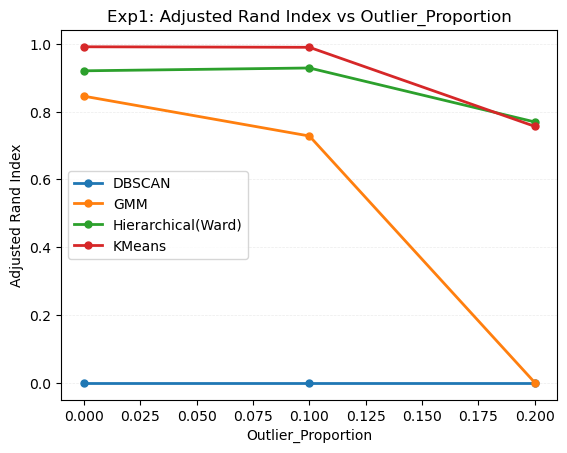

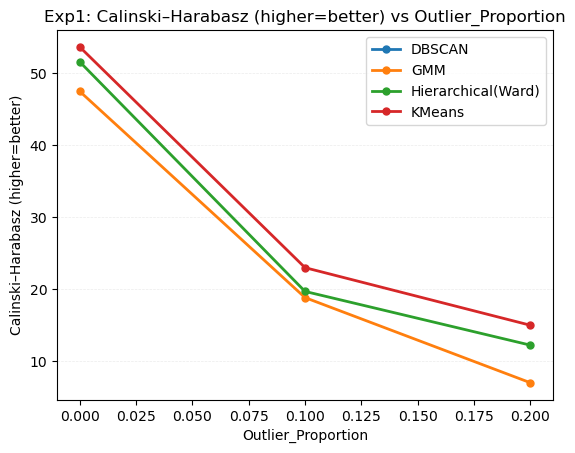

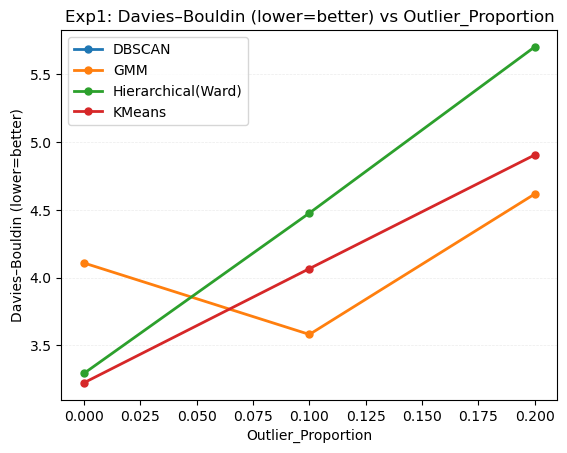

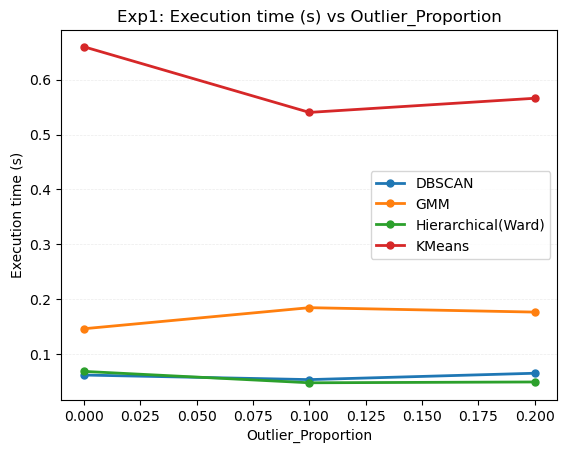

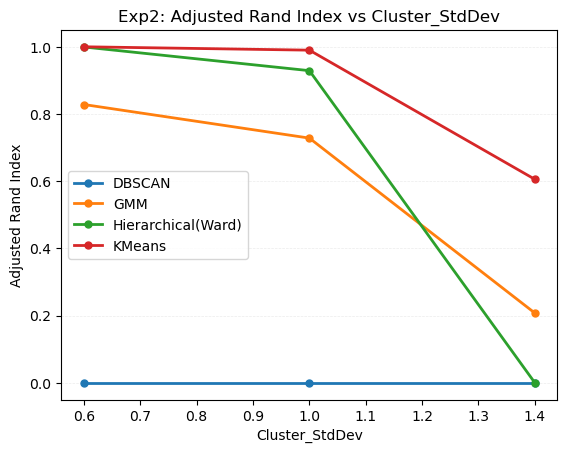

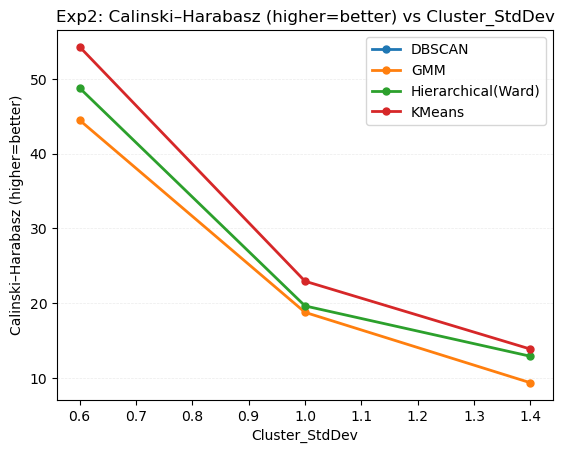

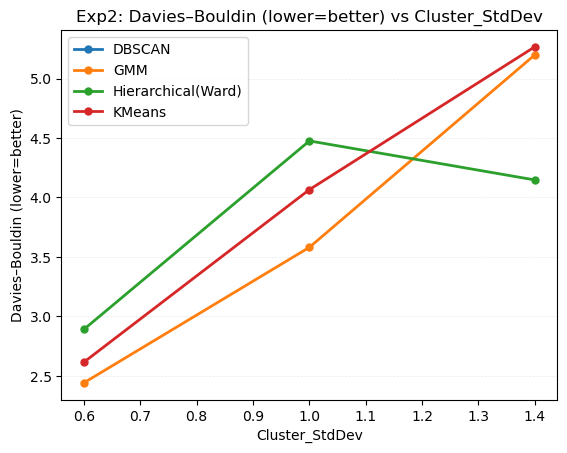

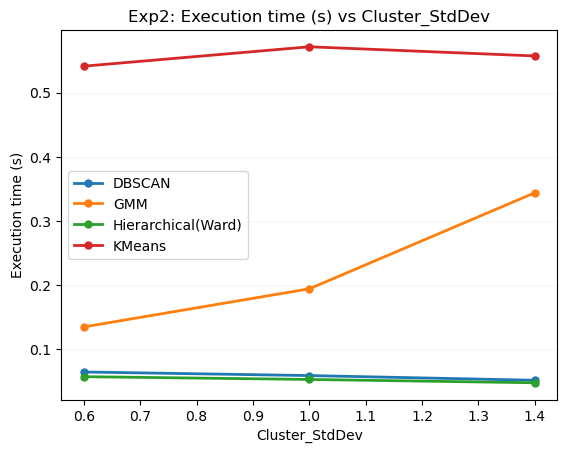

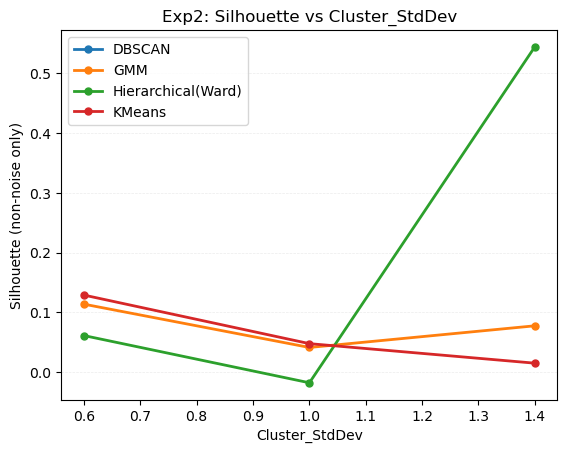

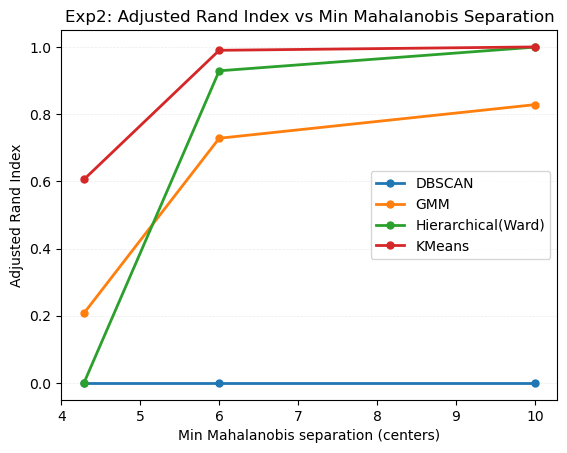

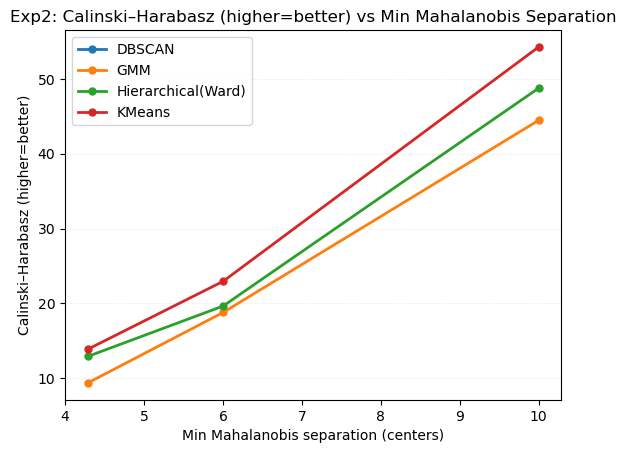

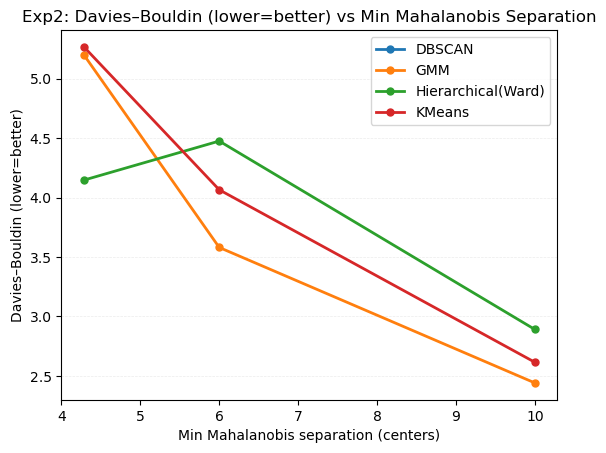

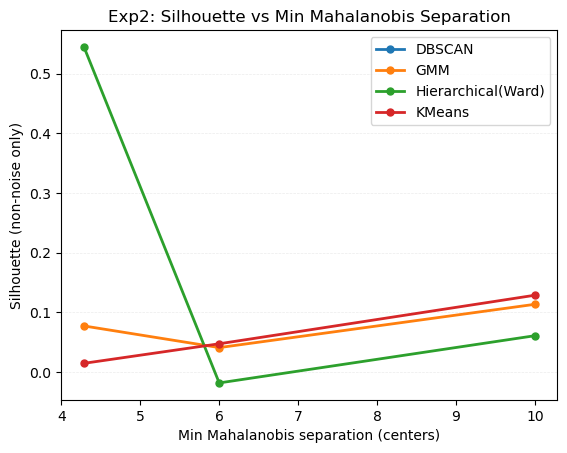

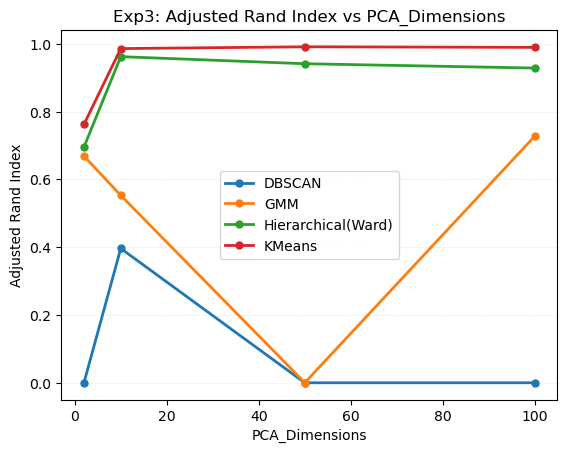

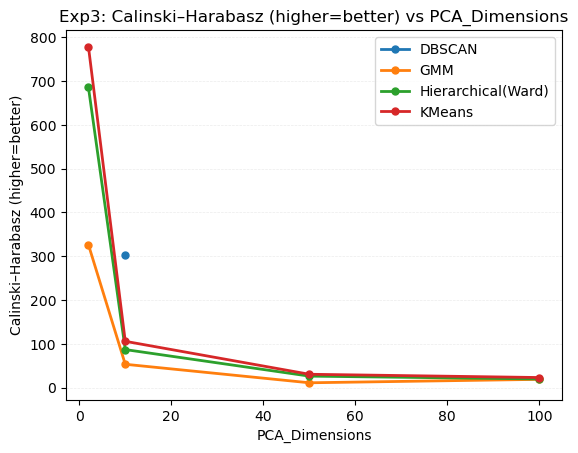

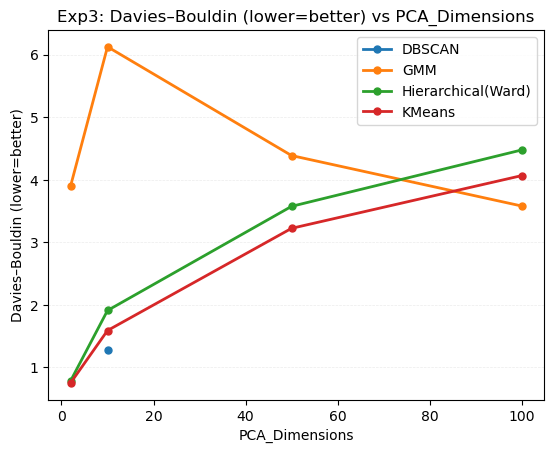

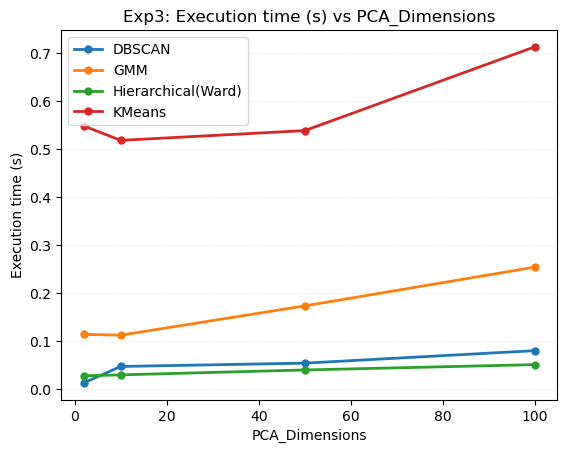

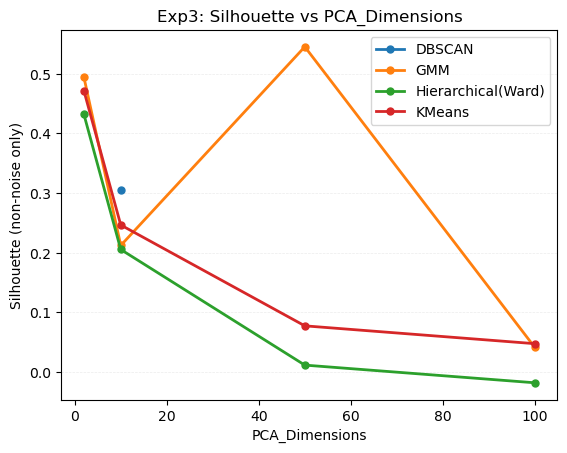

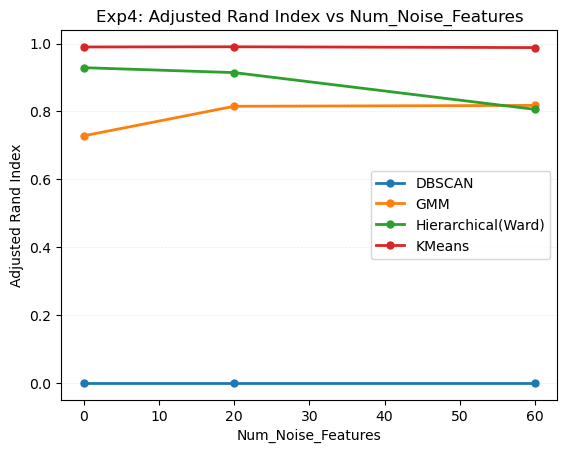

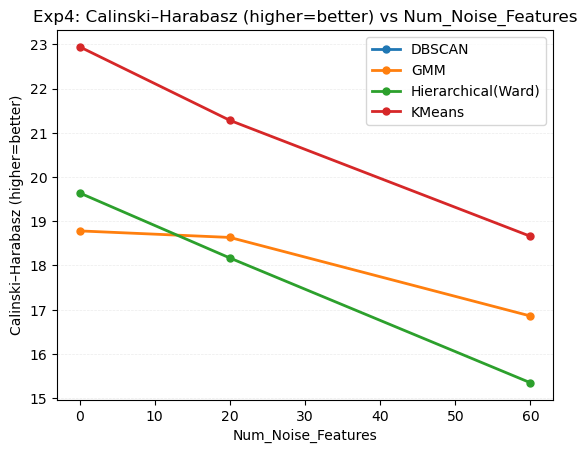

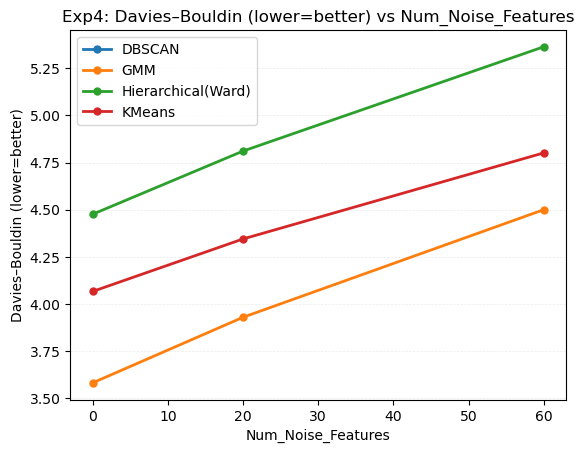

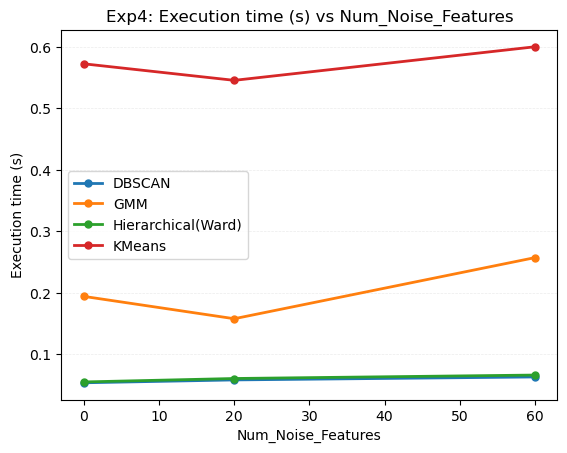

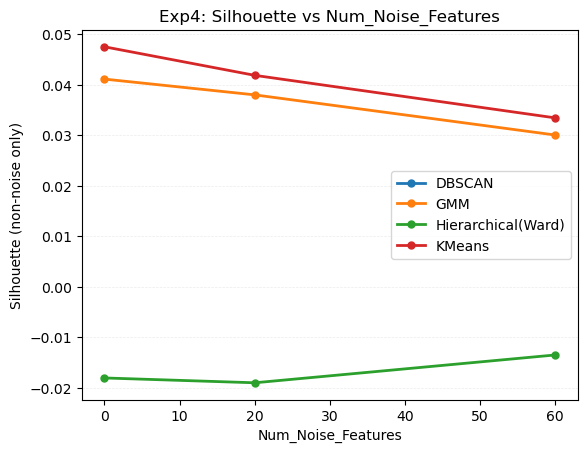

In [24]:

label_map = {
    "ari": "Adjusted Rand Index",
    "silhouette": "Silhouette (non-noise only)",
    "ch": "Calinski–Harabasz (higher=better)",
    "dbi": "Davies–Bouldin (lower=better)",
    "ExecTime_s": "Execution time (s)",
}

def plot_pack(df_agg, xname, title_prefix, plot_sil=True):
    """Render the standard pack of mean metric plots for an experiment."""
    if df_agg.empty:
        print(f"[plot_pack] No data for {title_prefix}")
        return
    for m in ("ari", "ch", "dbi", "ExecTime_s"):
        plot_mean(df_agg, xname, m, label_map[m], f"{title_prefix}: {label_map[m]} vs {xname}")
    if plot_sil:
        plot_mean(df_agg, xname, "silhouette", label_map["silhouette"],
                  f"{title_prefix}: Silhouette vs {xname}")

plot_pack(agg1, "Outlier_Proportion", "Exp1", plot_sil=PLOT_SIL_BY_EXP["Exp1_Outliers"])
plot_pack(agg2, "Cluster_StdDev", "Exp2", plot_sil=PLOT_SIL_BY_EXP["Exp2_StdDev"])

if not agg2.empty:
    for m in ("ari", "ch", "dbi"):
        plot_vs_mahalanobis(agg2, m, label_map[m], f"Exp2: {label_map[m]} vs Min Mahalanobis Separation")
    if PLOT_SIL_BY_EXP["Exp2_StdDev"]:
        plot_vs_mahalanobis(agg2, "silhouette", label_map["silhouette"], "Exp2: Silhouette vs Min Mahalanobis Separation")

plot_pack(agg3, "PCA_Dimensions", "Exp3", plot_sil=PLOT_SIL_BY_EXP["Exp3_PCA_Dims"])
plot_pack(agg4, "Num_Noise_Features", "Exp4", plot_sil=PLOT_SIL_BY_EXP["Exp4_FeatureNoise"])


Add bootstrap error bars to the same metrics for a quick sense of stability.

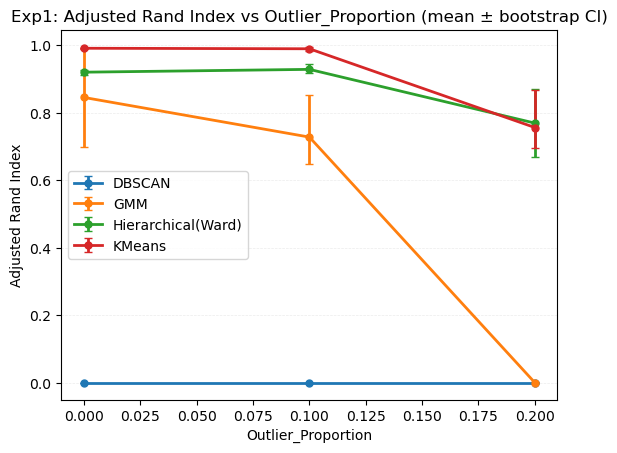

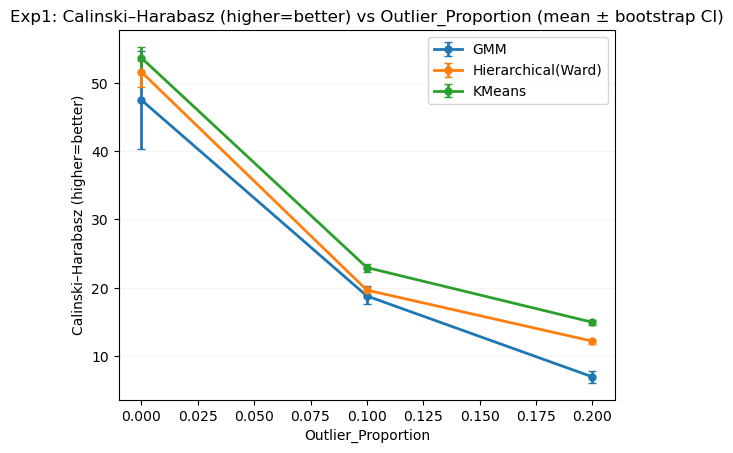

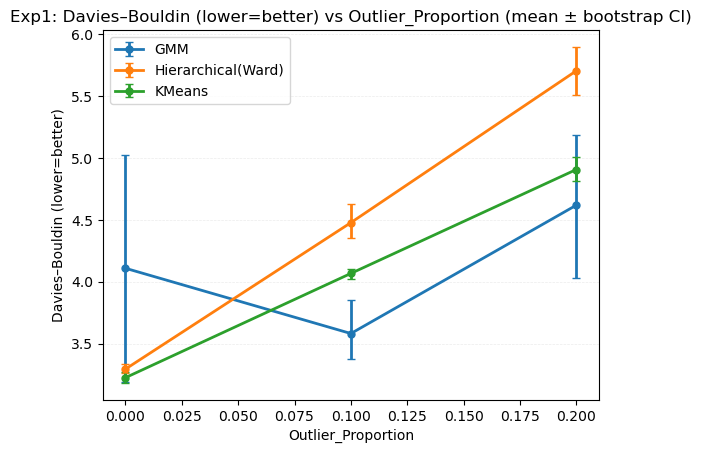

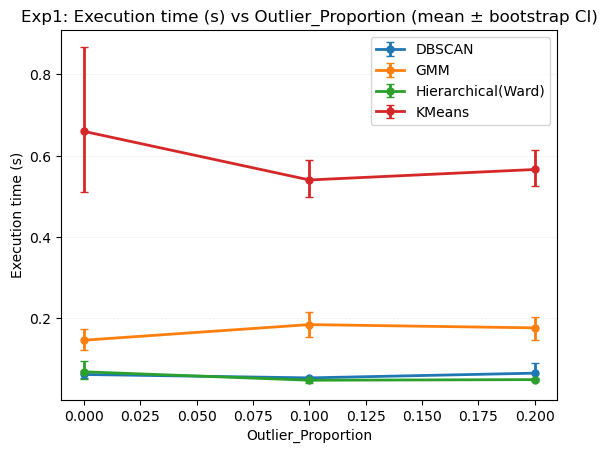

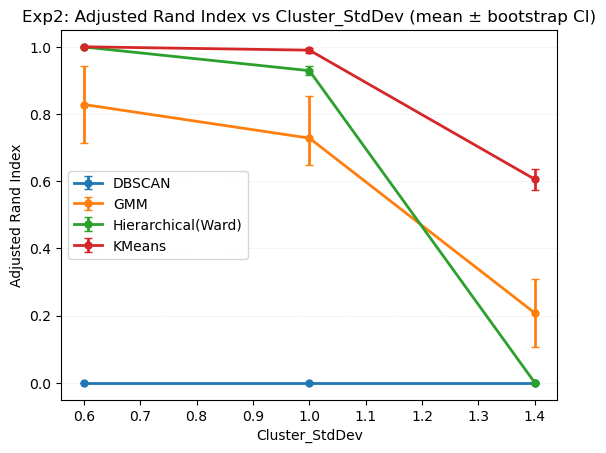

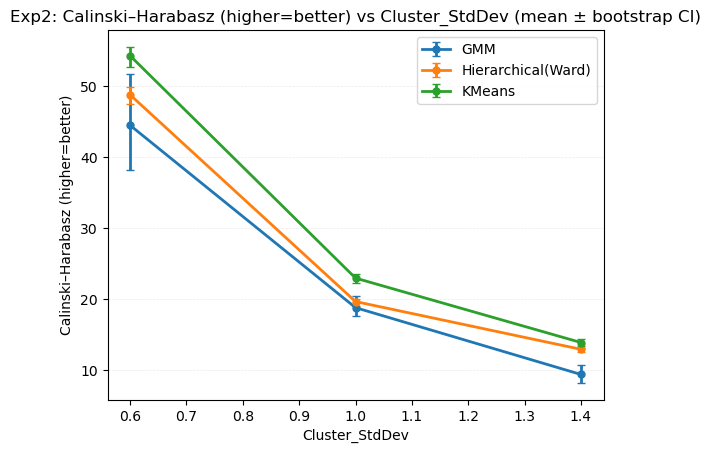

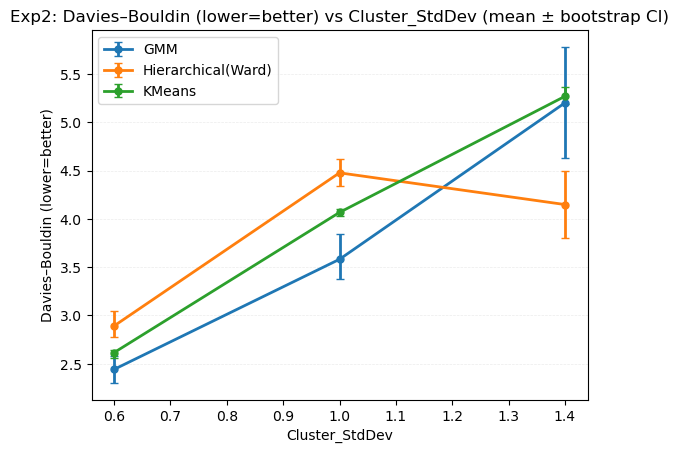

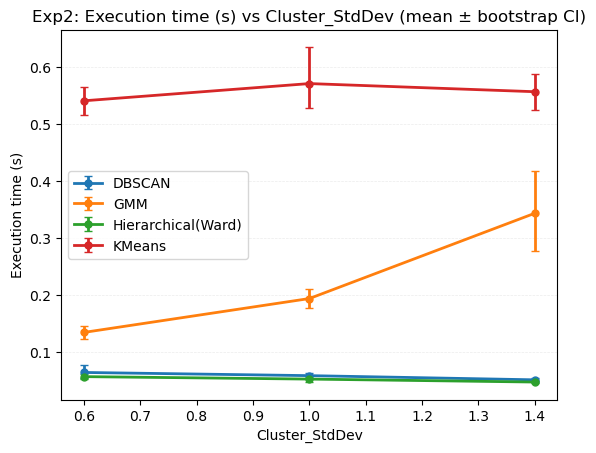

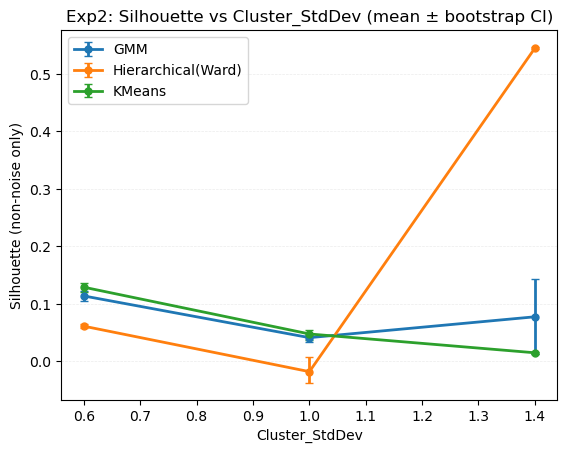

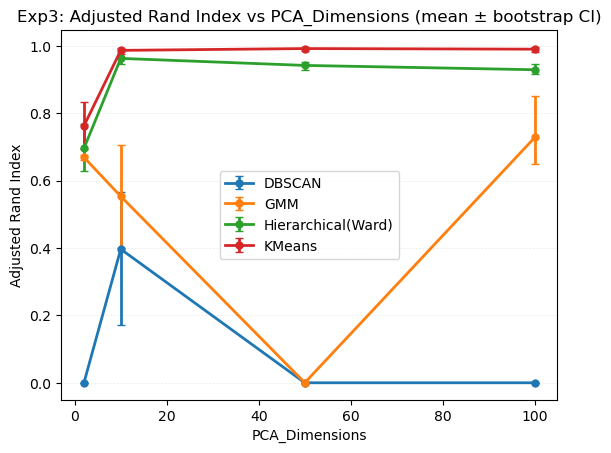

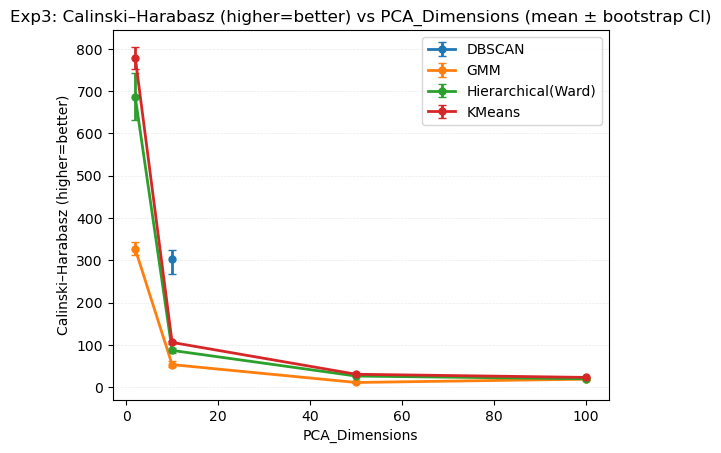

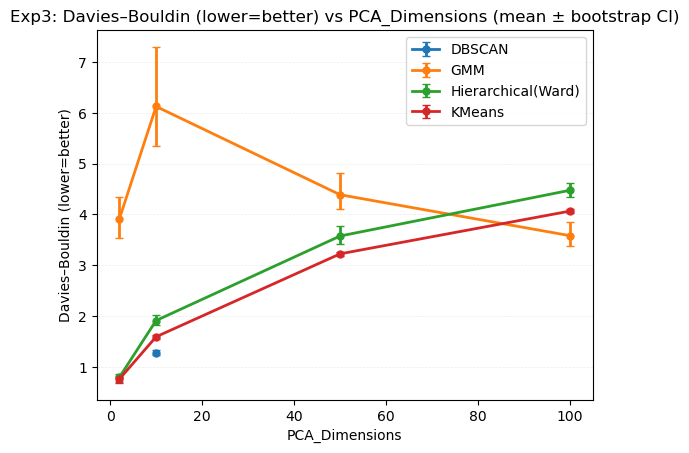

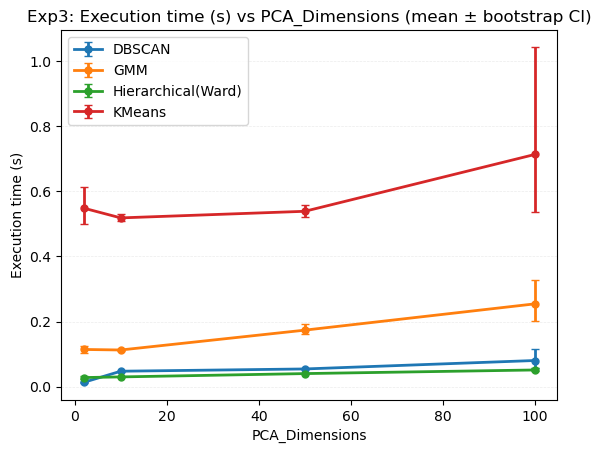

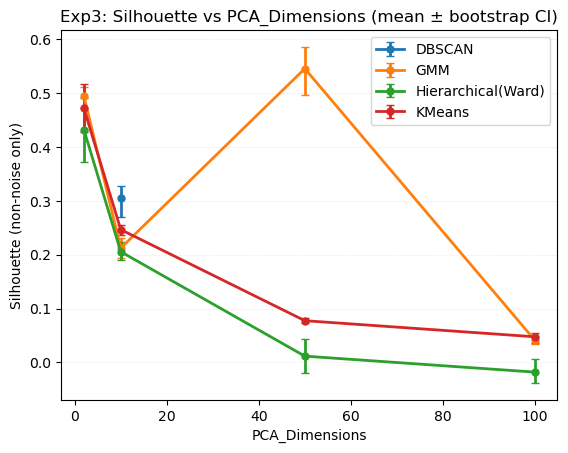

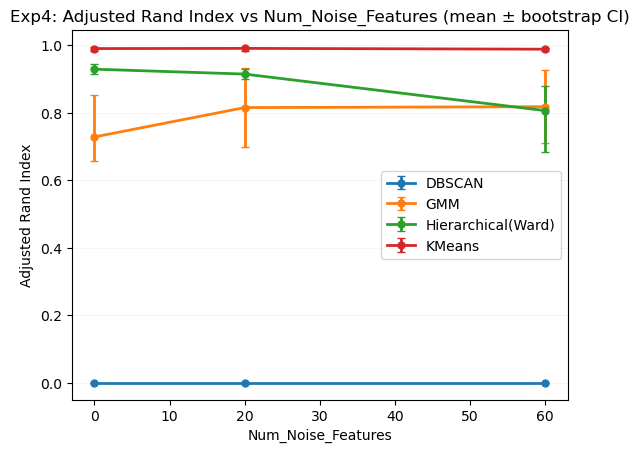

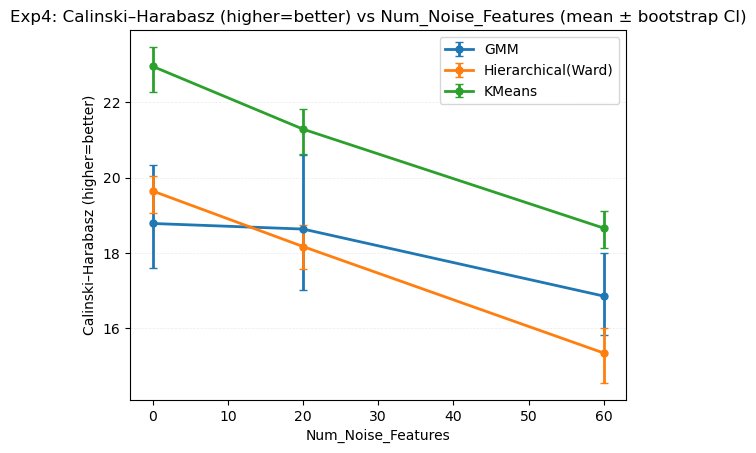

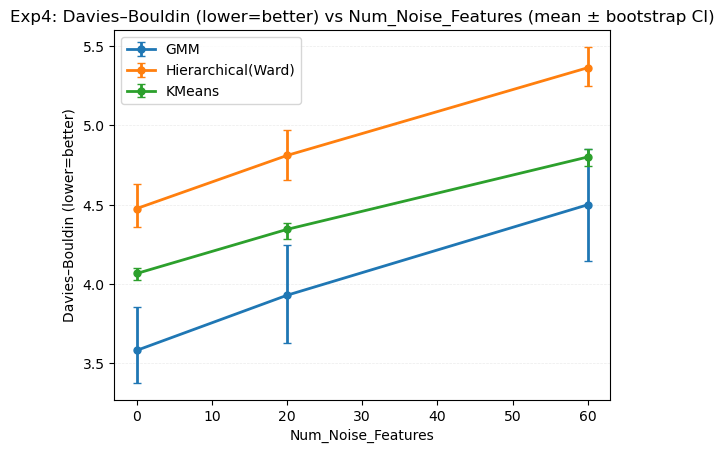

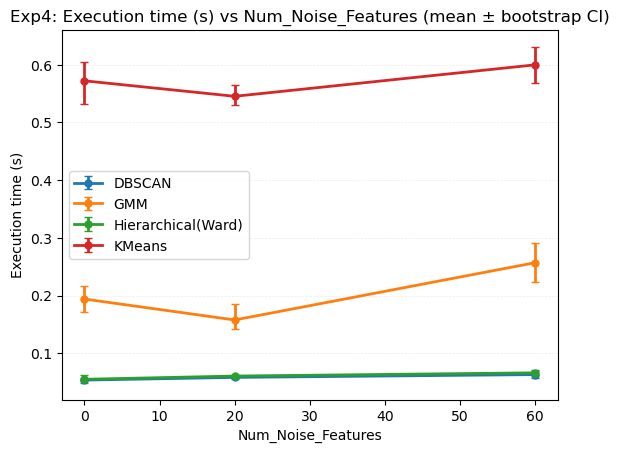

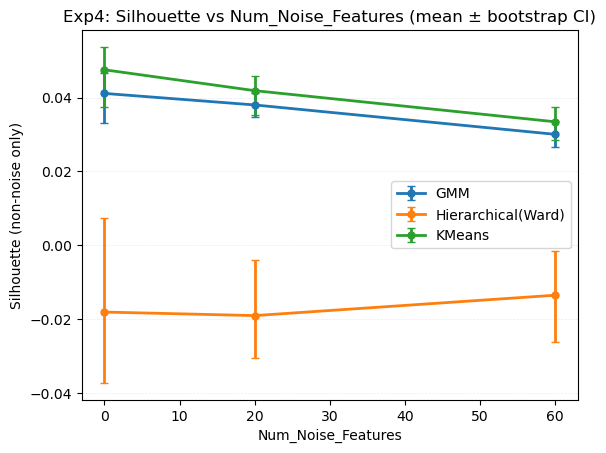

In [26]:

rng_ci = np.random.default_rng(TOP_SEED + 424242)
metrics_ci = list(METRICS) + ["ExecTime_s"]

def plot_pack_with_ci(exp_name: str, x_label: str, title_prefix: str, plot_sil=True):
    """Draw mean ± bootstrap CI for each metric across algorithms."""
    boot = add_bootstrap_for_metrics(df_all, exp_name, x_label, metrics_ci, B=B, rng=rng_ci)
    if boot.empty:
        print(f"[plot_pack_with_ci] No data for {title_prefix}")
        return
    for m in ("ari", "ch", "dbi", "ExecTime_s"):
        plot_mean_with_ci(boot, x_label, m, label_map[m],
                          f"{title_prefix}: {label_map[m]} vs {x_label}")
    if plot_sil:
        plot_mean_with_ci(boot, x_label, "silhouette", label_map["silhouette"],
                          f"{title_prefix}: Silhouette vs {x_label}")

plot_pack_with_ci("Exp1_Outliers", "Outlier_Proportion", "Exp1", plot_sil=PLOT_SIL_BY_EXP["Exp1_Outliers"])
plot_pack_with_ci("Exp2_StdDev",   "Cluster_StdDev",    "Exp2", plot_sil=PLOT_SIL_BY_EXP["Exp2_StdDev"])
plot_pack_with_ci("Exp3_PCA_Dims", "PCA_Dimensions",    "Exp3", plot_sil=PLOT_SIL_BY_EXP["Exp3_PCA_Dims"])
plot_pack_with_ci("Exp4_FeatureNoise", "Num_Noise_Features", "Exp4",
                  plot_sil=PLOT_SIL_BY_EXP["Exp4_FeatureNoise"])


Overlay per-seed dots on top of mean lines to expose variability.

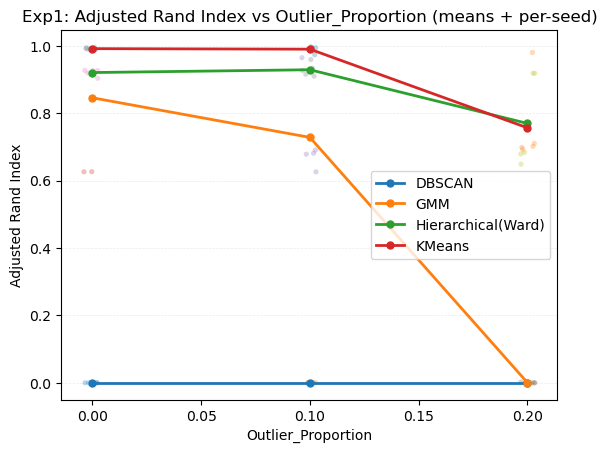

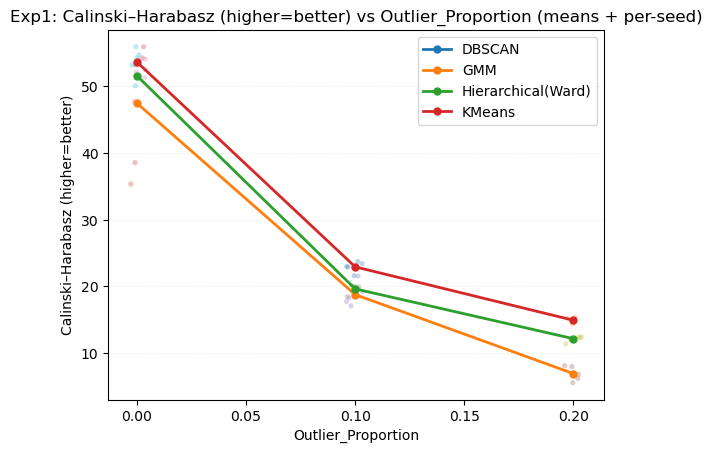

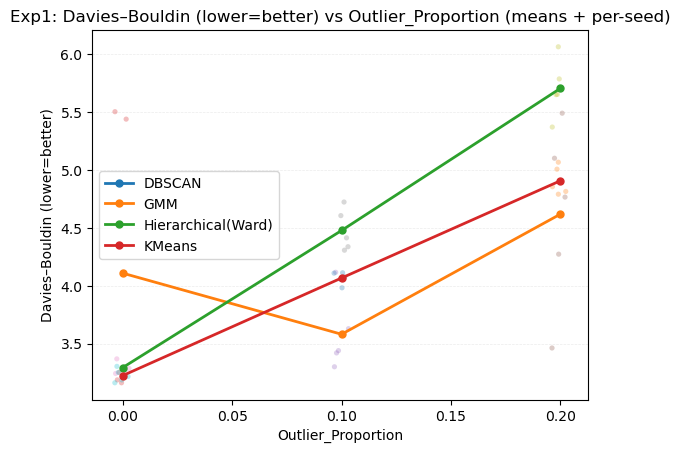

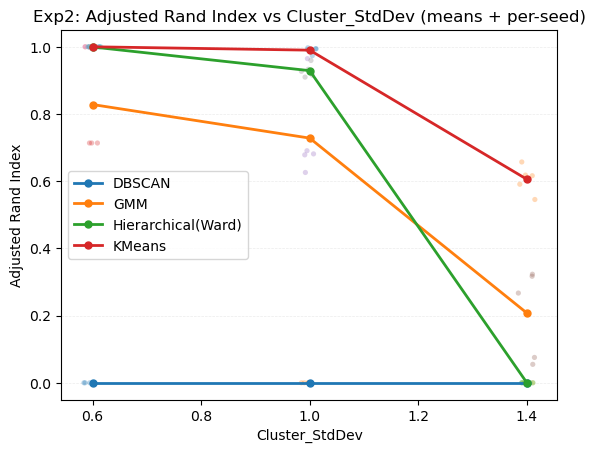

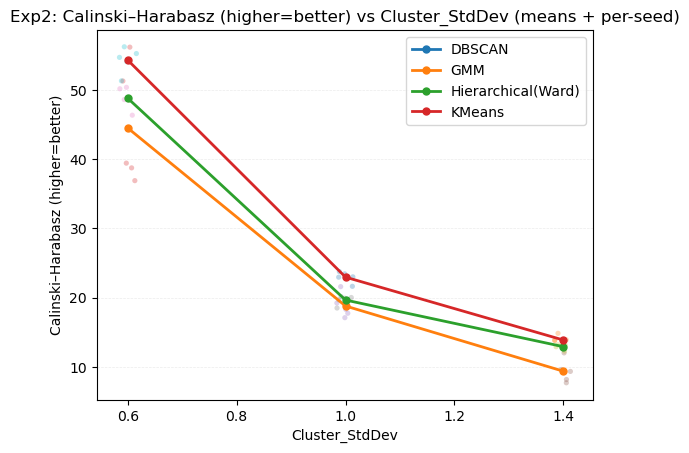

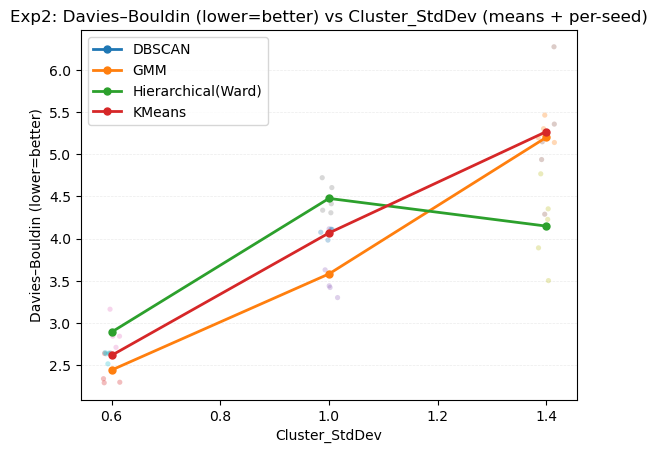

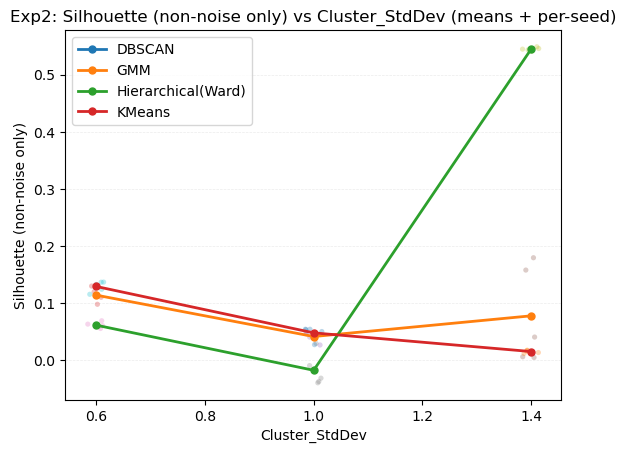

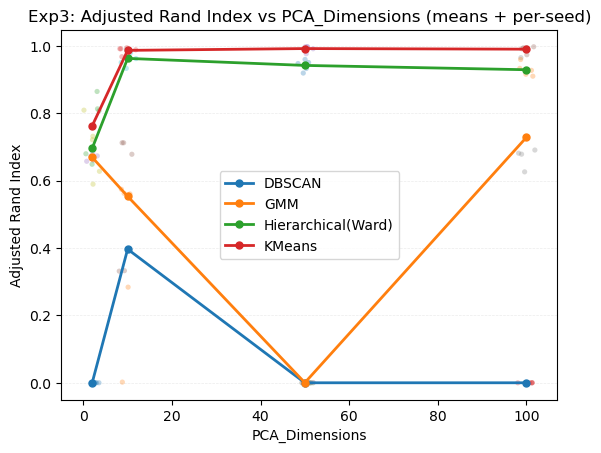

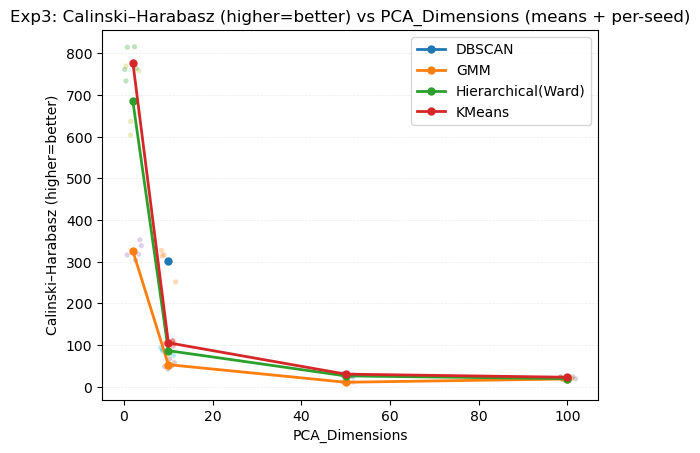

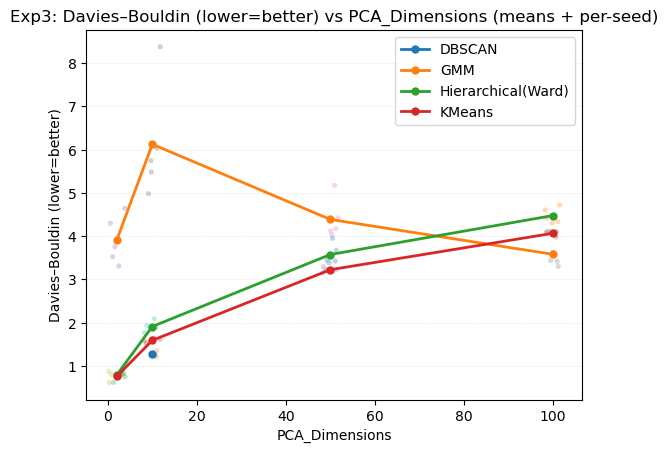

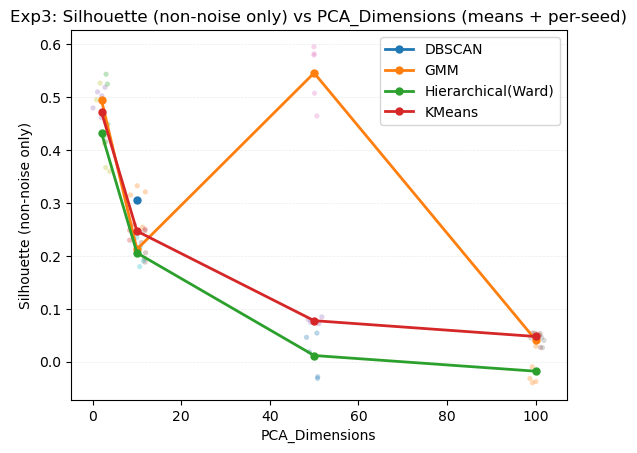

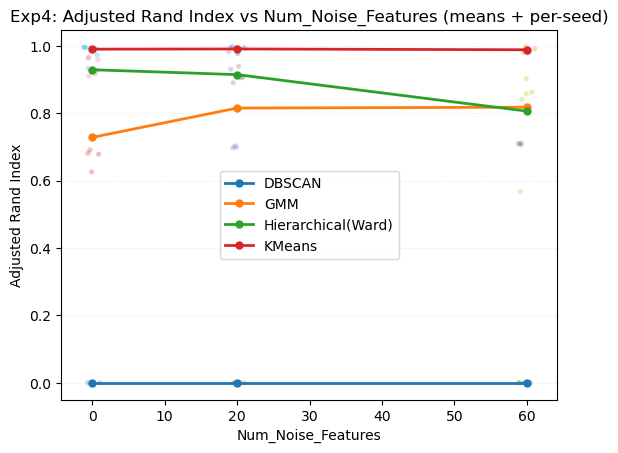

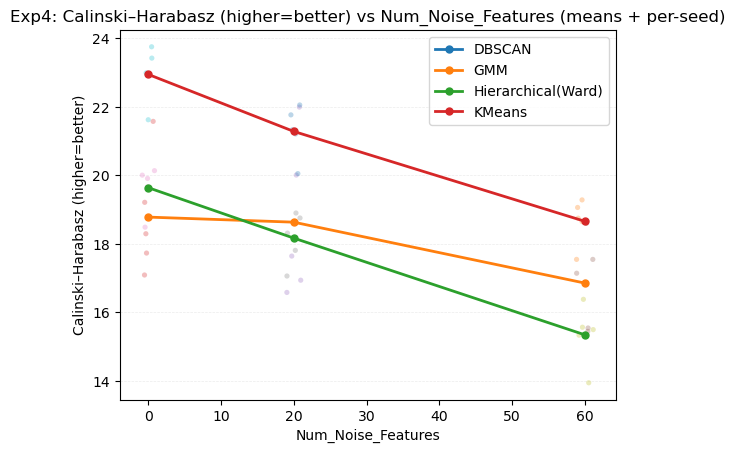

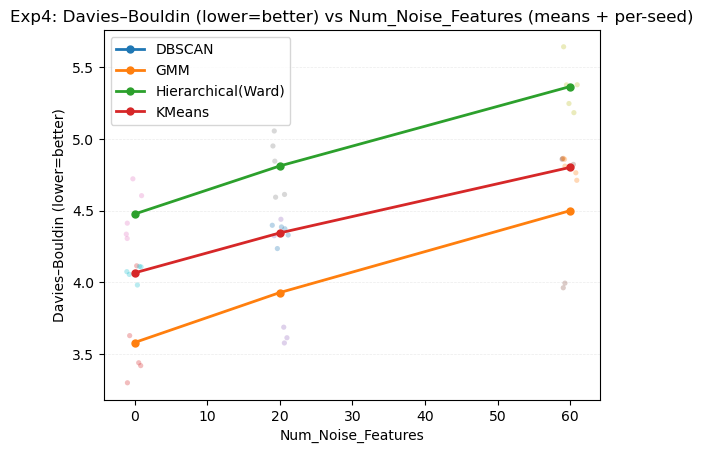

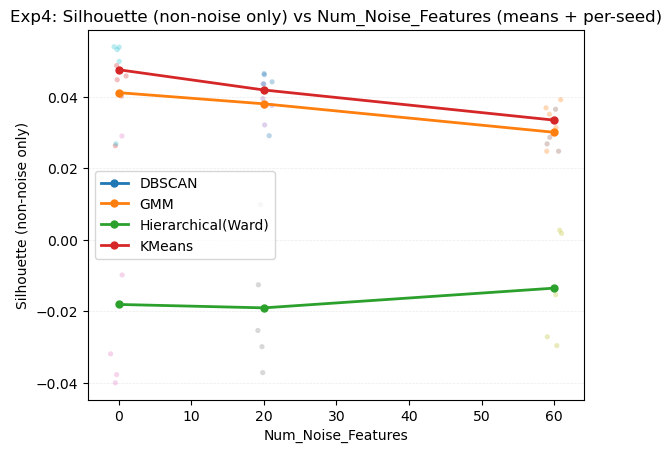

In [28]:

plot_with_seed_overlays(df_all, agg1, "Exp1_Outliers", "Outlier_Proportion", "Exp1",
                        plot_sil=False)
plot_with_seed_overlays(df_all, agg2, "Exp2_StdDev", "Cluster_StdDev", "Exp2",
                        plot_sil=PLOT_SIL_BY_EXP["Exp2_StdDev"])
plot_with_seed_overlays(df_all, agg3, "Exp3_PCA_Dims", "PCA_Dimensions", "Exp3",
                        plot_sil=PLOT_SIL_BY_EXP["Exp3_PCA_Dims"])
plot_with_seed_overlays(df_all, agg4, "Exp4_FeatureNoise", "Num_Noise_Features", "Exp4",
                        plot_sil=PLOT_SIL_BY_EXP["Exp4_FeatureNoise"])


Compare RAW k* vs PCA→k* as tables and simple grouped bar charts.

C:\Users\srivalli\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\srivalli\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\srivalli\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\srivalli\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory le

Exp5 raw rows:


k_star setting           algorithm  seed       ari  silhouette  \
0       10     RAW              KMeans  4911  0.997034    0.339728   
1       10     RAW                 GMM  4911  0.713603    0.307895   
2       10     RAW  Hierarchical(Ward)  4911  0.994074    0.332225   
3       10     RAW              DBSCAN  4911  0.829949    0.448164   
4       10     RAW            GMM(BIC)  4911  0.994074    0.354032   
5       10     PCA              KMeans  4911  0.985208    0.229417   
6       10     PCA                 GMM  4911  0.000000    0.585313   
7       10     PCA  Hierarchical(Ward)  4911  0.958930    0.160850   
8       10     PCA              DBSCAN  4911  0.001458         NaN   
9       10     PCA            GMM(BIC)  4911  0.698419    0.210609   
10      10     RAW              KMeans  8581  0.997034    0.379531   
11      10     RAW                 GMM  8581  0.991128    0.315480   
12      10     RAW  Hierarchical(Ward)  8581  0.985301    0.345081   
13      10     RAW              DBSCAN  8581  0.841892    0.496235   
14      10     RAW            GMM(BIC)  8581  0.994081    0.396059   
15      10     PCA              KMeans  8581  0.994074    0.237637   
16      10     PCA                 GMM  8581  0.697765    0.204804   
17      10     PCA  Hierarchical(Ward)  8581  0.959016    0.169344   
18      10     PCA              DBSCAN  8581 -0.000430         NaN   
19      10     PCA            GMM(BIC)  8581  0.697765    0.204804   
20      10     RAW              KMeans  2349  0.997034    0.339216   
21      10     RAW                 GMM  2349  0.991114    0.275592   
22      10     RAW  Hierarchical(Ward)  2349  0.997034    0.329973   
23      10     RAW              DBSCAN  2349  0.622745    0.393897   
24      10     RAW            GMM(BIC)  2349  1.000000    0.359407   
25      10     PCA              KMeans  2349  0.991141    0.248081   
26      10     PCA                 GMM  2349  0.699935    0.226596   
27      10     PCA  Hierarchical(Ward)  2349  0.941825    0.198247   
28      10     PCA              DBSCAN  2349  0.571715    0.322480   
29      10     PCA            GMM(BIC)  2349  0.699935    0.226596   
30      10     RAW              KMeans  2750  0.997034    0.316365   
31      10     RAW                 GMM  2750  0.709976    0.269141   
32      10     RAW  Hierarchical(Ward)  2750  0.997034    0.297467   
33      10     RAW              DBSCAN  2750  0.826616    0.427731   
34      10     RAW            GMM(BIC)  2750  0.994081    0.333885   
35      10     PCA              KMeans  2750  0.985248    0.268161   
36      10     PCA                 GMM  2750  0.701309    0.236513   
37      10     PCA  Hierarchical(Ward)  2750  0.973430    0.207100   
38      10     PCA              DBSCAN  2750  0.726328    0.397345   
39      10     PCA            GMM(BIC)  2750  0.701309    0.236513   
40      10     RAW              KMeans  8353  0.997034    0.376914   
41      10     RAW                 GMM  8353  0.713243    0.397889   
42      10     RAW  Hierarchical(Ward)  8353  0.997034    0.372495   
43      10     RAW              DBSCAN  8353  0.607240    0.494848   
44      10     RAW            GMM(BIC)  8353  0.995557    0.394299   
45      10     PCA              KMeans  8353  0.979316    0.226633   
46      10     PCA                 GMM  8353  0.316982    0.141094   
47      10     PCA  Hierarchical(Ward)  8353  0.938544    0.195714   
48      10     PCA              DBSCAN  8353  0.248938    0.198942   
49      10     PCA            GMM(BIC)  8353  0.970504    0.256822   

             ch       dbi  
0    268.414343  1.203366  
1    146.242121  4.988197  
2    237.920258  1.307879  
3    649.494650  0.900311  
4    156.269711  4.149227  
5    101.369335  1.595183  
6     25.752476  4.626616  
7     80.110561  1.884052  
8           NaN       NaN  
9     48.218265  5.952647  
10   424.455098  1.138559  
11   274.668124  1.419712  
12   375.384208  1.132136  
13  1109.451569  0.820476  
14   255.0662


Exp5 summary stats:


k_star  base_D           algorithm setting  ari_mean  silhouette_mean  \
0      10     100              DBSCAN     PCA  0.309602         0.306256   
1      10     100              DBSCAN     RAW  0.745688         0.452175   
2      10     100                 GMM     PCA  0.483198         0.278864   
3      10     100                 GMM     RAW  0.823813         0.313200   
4      10     100            GMM(BIC)     PCA  0.753586         0.227069   
5      10     100            GMM(BIC)     RAW  0.995559         0.367537   
6      10     100  Hierarchical(Ward)     PCA  0.954349         0.186251   
7      10     100  Hierarchical(Ward)     RAW  0.994095         0.335448   
8      10     100              KMeans     PCA  0.986997         0.241986   
9      10     100              KMeans     RAW  0.997034         0.350351   

      ch_mean  dbi_mean  
0  323.689363  1.270586  
1  761.373037  0.901765  
2   48.989364  5.238306  
3  195.136140  3.191380  
4   57.206593  5.737118  
5  184.450471  3.628020  
6   86.818177  1.898852  
7  282.709697  1.260251  
8  107.705405  1.579813  
9  321.988904  1.173579

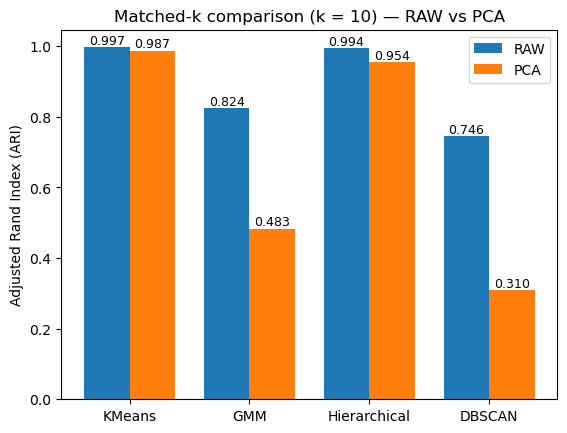

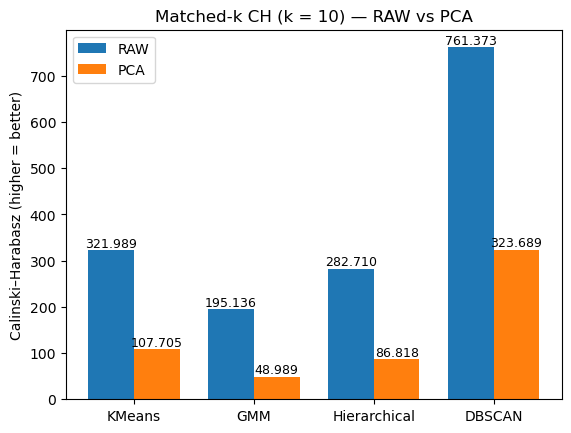

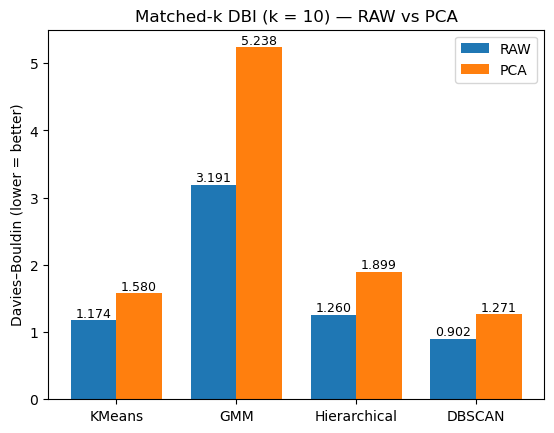

In [30]:

D_base = int(cfg["D"])
k_star = max(2, int(round(0.10 * D_base)))

def gen_raw_k(k:int, rng):
    """Generate data where the intrinsic dimensionality equals k."""
    return simulate_blobs(N, k, K_clusters, std=1.0, p_out=0.10,
                          min_sep=CENTER_MIN_SEP, rng=rng)

def gen_pca_from_base_to_k(k:int, rng):
    """Generate base D data and then reduce to k with PCA for comparison."""
    X, y_true, inlier_mask, centers, md_min = simulate_blobs(
        N, D_base, K_clusters, std=1.0, p_out=0.10, min_sep=CENTER_MIN_SEP, rng=rng
    )
    pca = PCA(n_components=int(k), random_state=int(rng.integers(0, 2**32-1)))
    Xp = pca.fit_transform(X)
    return Xp, y_true, inlier_mask, centers[:, :min(centers.shape[1], int(k))], md_min

rows_exp5 = []
for seed in SEEDS:
    rng = np.random.default_rng(int(seed) + TOP_SEED)

    Xr, y_true, inlier_mask, _, _ = gen_raw_k(k_star, rng)
    labels_map, info_map = run_algorithms_extended(Xr, std_for_eps=1.0, n_clusters=K_clusters, seed=int(seed))
    for algo, lab in labels_map.items():
        m = compute_metrics(Xr, y_true, inlier_mask, lab)
        rows_exp5.append({"k_star": k_star, "setting": "RAW", "algorithm": algo, "seed": int(seed), **m})

    Xp, y_true, inlier_mask, _, _ = gen_pca_from_base_to_k(k_star, rng)
    labels_map, info_map = run_algorithms_extended(Xp, std_for_eps=1.0, n_clusters=K_clusters, seed=int(seed))
    for algo, lab in labels_map.items():
        m = compute_metrics(Xp, y_true, inlier_mask, lab)
        rows_exp5.append({"k_star": k_star, "setting": "PCA", "algorithm": algo, "seed": int(seed), **m})

df5 = pd.DataFrame.from_records(rows_exp5)
print("Exp5 raw rows:")
display(df5)

agg5 = (df5.groupby(["algorithm", "setting"], as_index=False)
           .agg(ari_mean=("ari", "mean"),
                silhouette_mean=("silhouette", "mean"),
                ch_mean=("ch", "mean"),
                dbi_mean=("dbi", "mean")))
agg5.insert(0, "k_star", k_star)
agg5.insert(1, "base_D", D_base)
print("\nExp5 summary stats:")
display(agg5)

def plot_grouped_metric(metric_key: str, y_label: str, title: str):
    """Plot grouped bars for RAW vs PCA for each algorithm."""
    order_algos = list(ALGORITHMS)  # exclude GMM(BIC) as in comparisons
    order_sets = ["RAW", "PCA"]
    M = np.full((len(order_algos), len(order_sets)), np.nan, dtype=float)
    for i, a in enumerate(order_algos):
        for j, s in enumerate(order_sets):
            val = agg5.loc[(agg5["algorithm"] == a) & (agg5["setting"] == s), f"{metric_key}_mean"]
            if not val.empty:
                M[i, j] = float(val.iloc[0])

    x = np.arange(len(order_algos))
    width = 0.38

    plt.figure()
    ax = plt.gca()
    ax.grid(False)
    for j, s in enumerate(order_sets):
        plt.bar(x + (j-0.5)*width, M[:, j], width, label=s)
    for i in range(len(order_algos)):
        for j, dx in enumerate([-width/2, width/2]):
            v = M[i, j]
            if np.isfinite(v):
                plt.text(x[i] + dx, v, f"{v:.3f}", ha="center", va="bottom", fontsize=9)
    xtick_labels = [lbl.replace("Hierarchical(Ward)", "Hierarchical") for lbl in order_algos]
    plt.xticks(x, xtick_labels, rotation=0)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(loc="best", frameon=True)
    plt.show()

plot_grouped_metric("ari", "Adjusted Rand Index (ARI)", f"Matched‑k comparison (k = {k_star}) — RAW vs PCA")
plot_grouped_metric("ch",  "Calinski–Harabasz (higher = better)", f"Matched‑k CH (k = {k_star}) — RAW vs PCA")
plot_grouped_metric("dbi", "Davies–Bouldin (lower = better)", f"Matched‑k DBI (k = {k_star}) — RAW vs PCA")


Peek at PCA variance share to see how quickly energy accumulates.

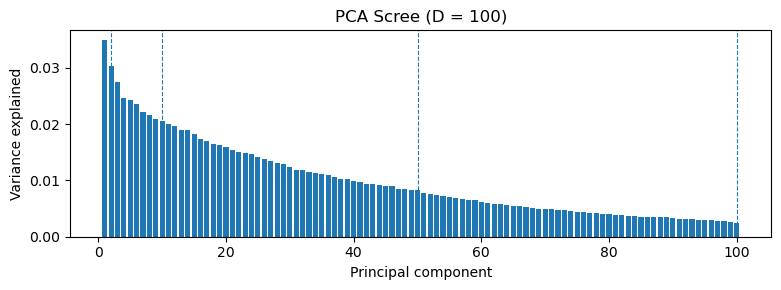

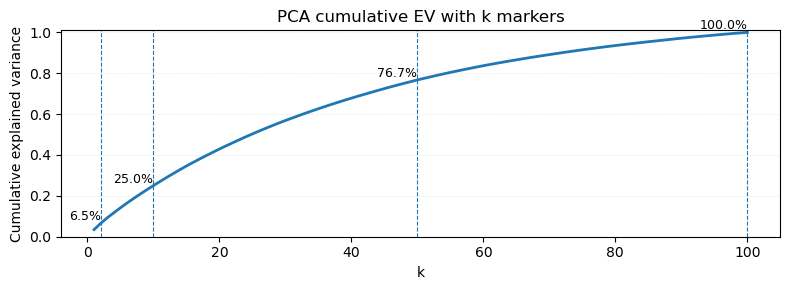

In [32]:

try:
    rng_vis = np.random.default_rng(TOP_SEED + 4242)
    X_vis, _, _, _, _ = simulate_blobs(N, D, K_clusters, std=1.0, p_out=0.10,
                                       min_sep=CENTER_MIN_SEP, rng=rng_vis)
    pca_vis = PCA(n_components=D, random_state=int(rng_vis.integers(0, 2**32-1))).fit(X_vis)
    evr = pca_vis.explained_variance_ratio_
    cum = np.cumsum(evr)
    Ks = list(cfg["GRID_EXP3_PCA_DIMS"])

    plt.figure(figsize=(8,3))
    plt.bar(np.arange(1, D+1), evr)
    for k in Ks:
        plt.axvline(k, linestyle="--", linewidth=0.8)
    plt.xlabel("Principal component"); plt.ylabel("Variance explained"); plt.title(f"PCA Scree (D = {D})")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(8,3))
    plt.plot(np.arange(1, D+1), cum, linewidth=2.0)
    for k in Ks:
        plt.axvline(k, linestyle="--", linewidth=0.8)
        plt.text(k, cum[k-1], f"{cum[k-1]*100:.1f}%", ha="right", va="bottom", fontsize=9)
    plt.ylim(0, 1.01)
    plt.xlabel("k"); plt.ylabel("Cumulative explained variance"); plt.title("PCA cumulative EV with k markers")
    ax = plt.gca(); ax.yaxis.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.25)
    ax.xaxis.grid(False); ax.set_axisbelow(True)
    plt.tight_layout(); plt.show()
except Exception as e:
    print("[WARN] Scree/cumulative EV plot skipped due to:", e)


Rank algorithms per condition by ARI to spot consistent winners.

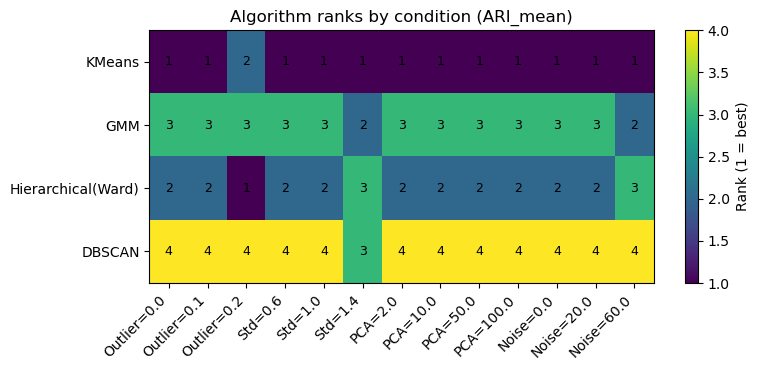

In [34]:

try:
    frames = []
    if not agg1.empty:
        t = agg1[["algorithm", "Outlier_Proportion", "ari_mean"]].copy()
        t["condition"] = "Outlier=" + t["Outlier_Proportion"].astype(str)
        frames.append(t[["algorithm", "condition", "ari_mean"]])
    if not agg2.empty:
        t = agg2[["algorithm", "Cluster_StdDev", "ari_mean"]].copy()
        t["condition"] = "Std=" + t["Cluster_StdDev"].astype(str)
        frames.append(t[["algorithm", "condition", "ari_mean"]])
    if not agg3.empty:
        t = agg3[["algorithm", "PCA_Dimensions", "ari_mean"]].copy()
        t["condition"] = "PCA=" + t["PCA_Dimensions"].astype(str)
        frames.append(t[["algorithm", "condition", "ari_mean"]])
    if not agg4.empty:
        t = agg4[["algorithm", "Num_Noise_Features", "ari_mean"]].copy()
        t["condition"] = "Noise=" + t["Num_Noise_Features"].astype(str)
        frames.append(t[["algorithm", "condition", "ari_mean"]])

    if frames:
        allc = pd.concat(frames, ignore_index=True)
        cond_order = list(dict.fromkeys(allc["condition"].tolist()))
        pivot = (allc.pivot(index="algorithm", columns="condition", values="ari_mean")
                      .reindex(columns=cond_order)
                      .reindex(index=list(ALGORITHMS)))
        ranked = pivot.rank(axis=0, ascending=False, method="min")

        plt.figure(figsize=(max(8, 0.5 * ranked.shape[1]), 2.2 + 0.4 * ranked.shape[0]))
        im = plt.imshow(ranked.values, aspect="auto", vmin=1, vmax=len(ranked.index))
        plt.xticks(range(ranked.shape[1]), ranked.columns, rotation=45, ha="right")
        plt.yticks(range(ranked.shape[0]), ranked.index)
        for i in range(ranked.shape[0]):
            for j in range(ranked.shape[1]):
                val = ranked.values[i, j]
                if np.isfinite(val):
                    plt.text(j, i, f"{int(val)}", ha="center", va="center", color="black", fontsize=9)
        cbar = plt.colorbar(im)
        cbar.set_label("Rank (1 = best)")
        plt.title("Algorithm ranks by condition (ARI_mean)")
        plt.tight_layout()
        plt.show()
    else:
        print("[INFO] No data for rank heatmap.")
except Exception as e:
    print("[WARN] Rank heatmap skipped due to:", e)


Show Wilcoxon pairwise tests with BH‑FDR for every experiment.

In [36]:

sig1 = pairwise_significance(df_all, "Exp1_Outliers", B=B)
sig2 = pairwise_significance(df_all, "Exp2_StdDev", B=B)
sig3 = pairwise_significance(df_all, "Exp3_PCA_Dims", B=B)
sig4 = pairwise_significance(df_all, "Exp4_FeatureNoise", B=B)

print("\nExp1_Outliers — pairwise Wilcoxon (BH‑FDR)")
display(sig1)
print("\nExp2_StdDev — pairwise Wilcoxon (BH‑FDR)")
display(sig2)
print("\nExp3_PCA_Dims — pairwise Wilcoxon (BH‑FDR)")
display(sig3)
print("\nExp4_FeatureNoise — pairwise Wilcoxon (BH‑FDR)")
display(sig4)


C:\Users\srivalli\anaconda3\Lib\site-packages\scipy\stats\_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\srivalli\anaconda3\Lib\site-packages\scipy\stats\_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\srivalli\anaconda3\Lib\site-packages\scipy\stats\_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\srivalli\anaconda3\Lib\site-packages\scipy\stats\_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\srivalli\anaconda3\Lib\site-packages\scipy\stats\_wilcoxon.py:199: UserWarning: Sample size too small for normal approximat


Exp1_Outliers — pairwise Wilcoxon (BH‑FDR)


experiment  param_value              algo_A              algo_B  \
0   Exp1_Outliers          0.0              DBSCAN                 GMM   
1   Exp1_Outliers          0.0              DBSCAN            GMM(BIC)   
2   Exp1_Outliers          0.0              DBSCAN  Hierarchical(Ward)   
3   Exp1_Outliers          0.0              DBSCAN              KMeans   
4   Exp1_Outliers          0.0                 GMM            GMM(BIC)   
5   Exp1_Outliers          0.0                 GMM  Hierarchical(Ward)   
6   Exp1_Outliers          0.0                 GMM              KMeans   
7   Exp1_Outliers          0.0            GMM(BIC)  Hierarchical(Ward)   
8   Exp1_Outliers          0.0            GMM(BIC)              KMeans   
9   Exp1_Outliers          0.0  Hierarchical(Ward)              KMeans   
10  Exp1_Outliers          0.1              DBSCAN                 GMM   
11  Exp1_Outliers          0.1              DBSCAN            GMM(BIC)   
12  Exp1_Outliers          0.1              DBSCAN  Hierarchical(Ward)   
13  Exp1_Outliers          0.1              DBSCAN              KMeans   
14  Exp1_Outliers          0.1                 GMM            GMM(BIC)   
15  Exp1_Outliers          0.1                 GMM  Hierarchical(Ward)   
16  Exp1_Outliers          0.1                 GMM              KMeans   
17  Exp1_Outliers          0.1            GMM(BIC)  Hierarchical(Ward)   
18  Exp1_Outliers          0.1            GMM(BIC)              KMeans   
19  Exp1_Outliers          0.1  Hierarchical(Ward)              KMeans   
20  Exp1_Outliers          0.2              DBSCAN                 GMM   
21  Exp1_Outliers          0.2              DBSCAN            GMM(BIC)   
22  Exp1_Outliers          0.2              DBSCAN  Hierarchical(Ward)   
23  Exp1_Outliers          0.2              DBSCAN              KMeans   
24  Exp1_Outliers          0.2                 GMM            GMM(BIC)   
25  Exp1_Outliers          0.2                 GMM  Hierarchical(Ward)   
26  Exp1_Outliers          0.2                 GMM              KMeans   
27  Exp1_Outliers          0.2            GMM(BIC)  Hierarchical(Ward)   
28  Exp1_Outliers          0.2            GMM(BIC)              KMeans   
29  Exp1_Outliers          0.2  Hierarchical(Ward)              KMeans   

    n_pairs  wilcoxon_stat   p_value  mean_diff_A_minus_B  \
0         5            0.0  0.062500            -0.845706   
1         5            0.0  1.000000             0.000000   
2         5            0.0  0.062500            -0.920561   
3         5            0.0  0.062500            -0.991474   
4         5            0.0  0.062500             0.845706   
5         5            6.0  0.812500            -0.074855   
6         5            0.0  0.179712            -0.145768   
7         5            0.0  0.062500            -0.920561   
8         5            0.0  0.062500            -0.991474   
9         5            0.0  0.062500            -0.070913   
10        5            0.0  0.062500            -0.728173   
11        5            0.0  0.179712            -0.002547   
12        5            0.0  0.062500            -0.928913   
13        5            0.0  0.062500            -0.989947   
14        5            0.0  0.062500             0.725625   
15        5            1.0  0.125000            -0.200740   
16        5            0.0  0.062500            -0.261774   
17        5            0.0  0.062500            -0.926366   
18        5            0.0  0.062500            -0.987399   
19        5            0.0  0.062500            -0.061033   
20        5            0.0  0.179712            -0.000373   
21        5            0.0  0.179712            -0.000373   
22        5            0.0  0.062500            -0.769616   
23        5            0.0  0.062500            -0.756599   
24        5            0.0  1.000000             0.000000   
25        5            0.0  0.062500            -0.769243   
26        5            0.0  0.062500            -0.756227   
27  


Exp2_StdDev — pairwise Wilcoxon (BH‑FDR)


experiment  param_value              algo_A              algo_B  n_pairs  \
0   Exp2_StdDev          0.6              DBSCAN                 GMM        5   
1   Exp2_StdDev          0.6              DBSCAN            GMM(BIC)        5   
2   Exp2_StdDev          0.6              DBSCAN  Hierarchical(Ward)        5   
3   Exp2_StdDev          0.6              DBSCAN              KMeans        5   
4   Exp2_StdDev          0.6                 GMM            GMM(BIC)        5   
5   Exp2_StdDev          0.6                 GMM  Hierarchical(Ward)        5   
6   Exp2_StdDev          0.6                 GMM              KMeans        5   
7   Exp2_StdDev          0.6            GMM(BIC)  Hierarchical(Ward)        5   
8   Exp2_StdDev          0.6            GMM(BIC)              KMeans        5   
9   Exp2_StdDev          0.6  Hierarchical(Ward)              KMeans        5   
10  Exp2_StdDev          1.0              DBSCAN                 GMM        5   
11  Exp2_StdDev          1.0              DBSCAN            GMM(BIC)        5   
12  Exp2_StdDev          1.0              DBSCAN  Hierarchical(Ward)        5   
13  Exp2_StdDev          1.0              DBSCAN              KMeans        5   
14  Exp2_StdDev          1.0                 GMM            GMM(BIC)        5   
15  Exp2_StdDev          1.0                 GMM  Hierarchical(Ward)        5   
16  Exp2_StdDev          1.0                 GMM              KMeans        5   
17  Exp2_StdDev          1.0            GMM(BIC)  Hierarchical(Ward)        5   
18  Exp2_StdDev          1.0            GMM(BIC)              KMeans        5   
19  Exp2_StdDev          1.0  Hierarchical(Ward)              KMeans        5   
20  Exp2_StdDev          1.4              DBSCAN                 GMM        5   
21  Exp2_StdDev          1.4              DBSCAN            GMM(BIC)        5   
22  Exp2_StdDev          1.4              DBSCAN  Hierarchical(Ward)        5   
23  Exp2_StdDev          1.4              DBSCAN              KMeans        5   
24  Exp2_StdDev          1.4                 GMM            GMM(BIC)        5   
25  Exp2_StdDev          1.4                 GMM  Hierarchical(Ward)        5   
26  Exp2_StdDev          1.4                 GMM              KMeans        5   
27  Exp2_StdDev          1.4            GMM(BIC)  Hierarchical(Ward)        5   
28  Exp2_StdDev          1.4            GMM(BIC)              KMeans        5   
29  Exp2_StdDev          1.4  Hierarchical(Ward)              KMeans        5   

    wilcoxon_stat   p_value  mean_diff_A_minus_B  median_diff_A_minus_B  \
0             0.0  0.062500            -0.828162              -0.713603   
1             0.0  1.000000             0.000000               0.000000   
2             0.0  0.062500            -0.999407              -1.000000   
3             0.0  0.062500            -1.000000              -1.000000   
4             0.0  0.062500             0.828162               0.713603   
5             1.0  0.130570            -0.171245              -0.286397   
6             0.0  0.083265            -0.171838              -0.286397   
7             0.0  0.062500            -0.999407              -1.000000   
8             0.0  0.062500            -1.000000              -1.000000   
9             0.0  0.317311            -0.000593               0.000000   
10            0.0  0.062500            -0.728173              -0.681241   
11            0.0  0.179712            -0.002547               0.000000   
12            0.0  0.062500            -0.928913              -0.927048   
13            0.0  0.062500            -0.989947              -0.994074   
14            0.0  0.062500             0.725625               0.681241   
15            1.0  0.125000            -0.200740              -0.245807   
16            0.0  0.062500            -0.261774              -0.312833   
17            0.0  0.062500            -0.926366              -0.927048   
18            0.0  0.062500            -0.987399              -0.991


Exp3_PCA_Dims — pairwise Wilcoxon (BH‑FDR)


experiment  param_value              algo_A              algo_B  \
0   Exp3_PCA_Dims          2.0              DBSCAN                 GMM   
1   Exp3_PCA_Dims          2.0              DBSCAN            GMM(BIC)   
2   Exp3_PCA_Dims          2.0              DBSCAN  Hierarchical(Ward)   
3   Exp3_PCA_Dims          2.0              DBSCAN              KMeans   
4   Exp3_PCA_Dims          2.0                 GMM            GMM(BIC)   
5   Exp3_PCA_Dims          2.0                 GMM  Hierarchical(Ward)   
6   Exp3_PCA_Dims          2.0                 GMM              KMeans   
7   Exp3_PCA_Dims          2.0            GMM(BIC)  Hierarchical(Ward)   
8   Exp3_PCA_Dims          2.0            GMM(BIC)              KMeans   
9   Exp3_PCA_Dims          2.0  Hierarchical(Ward)              KMeans   
10  Exp3_PCA_Dims         10.0              DBSCAN                 GMM   
11  Exp3_PCA_Dims         10.0              DBSCAN            GMM(BIC)   
12  Exp3_PCA_Dims         10.0              DBSCAN  Hierarchical(Ward)   
13  Exp3_PCA_Dims         10.0              DBSCAN              KMeans   
14  Exp3_PCA_Dims         10.0                 GMM            GMM(BIC)   
15  Exp3_PCA_Dims         10.0                 GMM  Hierarchical(Ward)   
16  Exp3_PCA_Dims         10.0                 GMM              KMeans   
17  Exp3_PCA_Dims         10.0            GMM(BIC)  Hierarchical(Ward)   
18  Exp3_PCA_Dims         10.0            GMM(BIC)              KMeans   
19  Exp3_PCA_Dims         10.0  Hierarchical(Ward)              KMeans   
20  Exp3_PCA_Dims         50.0              DBSCAN                 GMM   
21  Exp3_PCA_Dims         50.0              DBSCAN            GMM(BIC)   
22  Exp3_PCA_Dims         50.0              DBSCAN  Hierarchical(Ward)   
23  Exp3_PCA_Dims         50.0              DBSCAN              KMeans   
24  Exp3_PCA_Dims         50.0                 GMM            GMM(BIC)   
25  Exp3_PCA_Dims         50.0                 GMM  Hierarchical(Ward)   
26  Exp3_PCA_Dims         50.0                 GMM              KMeans   
27  Exp3_PCA_Dims         50.0            GMM(BIC)  Hierarchical(Ward)   
28  Exp3_PCA_Dims         50.0            GMM(BIC)              KMeans   
29  Exp3_PCA_Dims         50.0  Hierarchical(Ward)              KMeans   
30  Exp3_PCA_Dims        100.0              DBSCAN                 GMM   
31  Exp3_PCA_Dims        100.0              DBSCAN            GMM(BIC)   
32  Exp3_PCA_Dims        100.0              DBSCAN  Hierarchical(Ward)   
33  Exp3_PCA_Dims        100.0              DBSCAN              KMeans   
34  Exp3_PCA_Dims        100.0                 GMM            GMM(BIC)   
35  Exp3_PCA_Dims        100.0                 GMM  Hierarchical(Ward)   
36  Exp3_PCA_Dims        100.0                 GMM              KMeans   
37  Exp3_PCA_Dims        100.0            GMM(BIC)  Hierarchical(Ward)   
38  Exp3_PCA_Dims        100.0            GMM(BIC)              KMeans   
39  Exp3_PCA_Dims        100.0  Hierarchical(Ward)              KMeans   

    n_pairs  wilcoxon_stat   p_value  mean_diff_A_minus_B  \
0         5            0.0  0.062500            -0.669062   
1         5            0.0  0.062500            -0.669062   
2         5            0.0  0.062500            -0.695680   
3         5            0.0  0.062500            -0.762469   
4         5            0.0  1.000000             0.000000   
5         5            4.0  0.437500            -0.026618   
6         5            2.0  0.187500            -0.093407   
7         5            4.0  0.437500            -0.026618   
8         5            2.0  0.187500            -0.093407   
9         5            0.0  0.062500            -0.066789   
10        5            4.0  0.437500            -0.156741   
11        5            0.0  0.062500            -0.307814   
12        5            0.0  0.062500            -0.566067   
13        5            0.0  0.062500            -0.589887   
14        5            0.0  0.179712            -0.151073


Exp4_FeatureNoise — pairwise Wilcoxon (BH‑FDR)


experiment  param_value              algo_A              algo_B  \
0   Exp4_FeatureNoise          0.0              DBSCAN                 GMM   
1   Exp4_FeatureNoise          0.0              DBSCAN            GMM(BIC)   
2   Exp4_FeatureNoise          0.0              DBSCAN  Hierarchical(Ward)   
3   Exp4_FeatureNoise          0.0              DBSCAN              KMeans   
4   Exp4_FeatureNoise          0.0                 GMM            GMM(BIC)   
5   Exp4_FeatureNoise          0.0                 GMM  Hierarchical(Ward)   
6   Exp4_FeatureNoise          0.0                 GMM              KMeans   
7   Exp4_FeatureNoise          0.0            GMM(BIC)  Hierarchical(Ward)   
8   Exp4_FeatureNoise          0.0            GMM(BIC)              KMeans   
9   Exp4_FeatureNoise          0.0  Hierarchical(Ward)              KMeans   
10  Exp4_FeatureNoise         20.0              DBSCAN                 GMM   
11  Exp4_FeatureNoise         20.0              DBSCAN            GMM(BIC)   
12  Exp4_FeatureNoise         20.0              DBSCAN  Hierarchical(Ward)   
13  Exp4_FeatureNoise         20.0              DBSCAN              KMeans   
14  Exp4_FeatureNoise         20.0                 GMM            GMM(BIC)   
15  Exp4_FeatureNoise         20.0                 GMM  Hierarchical(Ward)   
16  Exp4_FeatureNoise         20.0                 GMM              KMeans   
17  Exp4_FeatureNoise         20.0            GMM(BIC)  Hierarchical(Ward)   
18  Exp4_FeatureNoise         20.0            GMM(BIC)              KMeans   
19  Exp4_FeatureNoise         20.0  Hierarchical(Ward)              KMeans   
20  Exp4_FeatureNoise         60.0              DBSCAN                 GMM   
21  Exp4_FeatureNoise         60.0              DBSCAN            GMM(BIC)   
22  Exp4_FeatureNoise         60.0              DBSCAN  Hierarchical(Ward)   
23  Exp4_FeatureNoise         60.0              DBSCAN              KMeans   
24  Exp4_FeatureNoise         60.0                 GMM            GMM(BIC)   
25  Exp4_FeatureNoise         60.0                 GMM  Hierarchical(Ward)   
26  Exp4_FeatureNoise         60.0                 GMM              KMeans   
27  Exp4_FeatureNoise         60.0            GMM(BIC)  Hierarchical(Ward)   
28  Exp4_FeatureNoise         60.0            GMM(BIC)              KMeans   
29  Exp4_FeatureNoise         60.0  Hierarchical(Ward)              KMeans   

    n_pairs  wilcoxon_stat   p_value  mean_diff_A_minus_B  \
0         5            0.0  0.062500            -0.728173   
1         5            0.0  0.179712            -0.002547   
2         5            0.0  0.062500            -0.928913   
3         5            0.0  0.062500            -0.989947   
4         5            0.0  0.062500             0.725625   
5         5            1.0  0.125000            -0.200740   
6         5            0.0  0.062500            -0.261774   
7         5            0.0  0.062500            -0.926366   
8         5            0.0  0.062500            -0.987399   
9         5            0.0  0.062500            -0.061033   
10        5            0.0  0.062500            -0.815166   
11        5            0.0  0.317311            -0.000578   
12        5            0.0  0.062500            -0.914401   
13        5            0.0  0.062500            -0.990535   
14        5            0.0  0.062500             0.814587   
15        5            3.0  0.312500            -0.099236   
16        5            2.0  0.187500            -0.175369   
17        5            0.0  0.062500            -0.913823   
18        5            0.0  0.062500            -0.989956   
19        5            0.0  0.062500            -0.076133   
20        5            0.0  0.062500            -0.817725   
21        5            0.0  1.000000             0.000000   
22        5            0.0  0.062500            -0.806087   
23        5            0.0  0.062500            -0.988159   
24        5            0.0  0.062500             0.817725   
25    

Merge ARI CIs into the aggregates and show the final wide summary table.

In [38]:

rng_boot = np.random.default_rng(TOP_SEED + 9999)
ari_ci_1 = add_ari_bootstrap(df_all, "Exp1_Outliers", "Outlier_Proportion", B=B, rng=rng_boot)
ari_ci_2 = add_ari_bootstrap(df_all, "Exp2_StdDev", "Cluster_StdDev", B=B, rng=rng_boot)
ari_ci_3 = add_ari_bootstrap(df_all, "Exp3_PCA_Dims", "PCA_Dimensions", B=B, rng=rng_boot)
ari_ci_4 = add_ari_bootstrap(df_all, "Exp4_FeatureNoise", "Num_Noise_Features", B=B, rng=rng_boot)
ari_ci_all = pd.concat([x for x in [ari_ci_1, ari_ci_2, ari_ci_3, ari_ci_4] if not x.empty], ignore_index=True)

def final_table(agg_df, exp_name, x_label):
    """Join ARI bootstrap CIs to aggregates for a single tidy view."""
    if agg_df.empty: return pd.DataFrame()
    sub_ci = ari_ci_all[ari_ci_all["experiment"] == exp_name]
    cols_keep = ["algorithm", x_label, "mahalanobis_min_mean"] +                 [c for c in agg_df.columns if any(c.startswith(m+"_") for m in METRICS)] +                 ["ExecTime_s_mean", "ExecTime_s_median", "ExecTime_s_q05", "ExecTime_s_q95"]
    base = agg_df[cols_keep].copy()
    return base.merge(sub_ci.drop(columns=["mahalanobis_min_mean"]), on=["algorithm", x_label], how="left")

fin1 = final_table(agg1, "Exp1_Outliers", "Outlier_Proportion")
fin2 = final_table(agg2, "Exp2_StdDev", "Cluster_StdDev")
fin3 = final_table(agg3, "Exp3_PCA_Dims", "PCA_Dimensions")
fin4 = final_table(agg4, "Exp4_FeatureNoise", "Num_Noise_Features")

summary_final = pd.concat([x for x in [fin1, fin2, fin3, fin4] if not x.empty], ignore_index=True)
print("Final summary table:")
display(summary_final)


Final summary table:


algorithm  Outlier_Proportion  mahalanobis_min_mean  \
0               DBSCAN                 0.0              6.000000   
1               DBSCAN                 0.1              6.000000   
2               DBSCAN                 0.2              6.000000   
3                  GMM                 0.0              6.000000   
4                  GMM                 0.1              6.000000   
5                  GMM                 0.2              6.000000   
6             GMM(BIC)                 0.0              6.000000   
7             GMM(BIC)                 0.1              6.000000   
8             GMM(BIC)                 0.2              6.000000   
9   Hierarchical(Ward)                 0.0              6.000000   
10  Hierarchical(Ward)                 0.1              6.000000   
11  Hierarchical(Ward)                 0.2              6.000000   
12              KMeans                 0.0              6.000000   
13              KMeans                 0.1              6.000000   
14              KMeans                 0.2              6.000000   
15              DBSCAN                 NaN             10.000000   
16              DBSCAN                 NaN              6.000000   
17              DBSCAN                 NaN              4.285714   
18                 GMM                 NaN             10.000000   
19                 GMM                 NaN              6.000000   
20                 GMM                 NaN              4.285714   
21            GMM(BIC)                 NaN             10.000000   
22            GMM(BIC)                 NaN              6.000000   
23            GMM(BIC)                 NaN              4.285714   
24  Hierarchical(Ward)                 NaN             10.000000   
25  Hierarchical(Ward)                 NaN              6.000000   
26  Hierarchical(Ward)                 NaN              4.285714   
27              KMeans                 NaN             10.000000   
28              KMeans                 NaN              6.000000   
29              KMeans                 NaN              4.285714   
30              DBSCAN                 NaN              6.000000   
31              DBSCAN                 NaN              6.000000   
32              DBSCAN                 NaN              6.000000   
33              DBSCAN                 NaN              6.000000   
34                 GMM                 NaN              6.000000   
35                 GMM                 NaN              6.000000   
36                 GMM                 NaN              6.000000   
37                 GMM                 NaN              6.000000   
38            GMM(BIC)                 NaN              6.000000   
39            GMM(BIC)                 NaN              6.000000   
40            GMM(BIC)                 NaN              6.000000   
41            GMM(BIC)                 NaN              6.000000   
42  Hierarchical(Ward)                 NaN              6.000000   
43  Hierarchical(Ward)                 NaN              6.000000   
44  Hierarchical(Ward)                 NaN              6.000000   
45  Hierarchical(Ward)                 NaN              6.000000   
46              KMeans                 NaN              6.000000   
47              KMeans                 NaN              6.000000   
48              KMeans                 NaN              6.000000   
49              KMeans                 NaN              6.000000   
50              DBSCAN                 NaN              6.000000   
51              DBSCAN                 NaN              6.000000   
52              DBSCAN                 NaN              6.000000   
53                 GMM                 NaN              6.000000   
54                 GMM                 NaN              6.000000   
55                 GMM                 NaN              6.000000   
56            GMM(BIC)                 NaN              6.000000   
57            GMM(BIC)                 NaN              6.000000   
5